In [1]:
import datetime; datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")

'2022-02-08 15:06:54'

# wip

In [119]:
import mariadb
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import itertools
%matplotlib inline

In [120]:
import matplotlib.pyplot as plt
#%matplotlib inline
import seaborn as sns
sns.set(
rc={
 'axes.axisbelow': False,
 'axes.edgecolor': 'black',
 'axes.facecolor': 'None',
 'axes.grid': False,
 "grid.color": "lightgrey",
 'axes.labelcolor': 'black',
 'axes.spines.right': False,
 'axes.spines.top': False,
 'figure.facecolor': 'white',
 'lines.solid_capstyle': 'round',
 'patch.edgecolor': 'w',
 'patch.force_edgecolor': True,
 'text.color': 'black',
 'xtick.bottom': False,
 'xtick.color': 'black',
 'xtick.direction': 'out',
 'xtick.top': False,
 'ytick.color': 'black',
 'ytick.direction': 'out',
 'ytick.left': False,
 'ytick.right': False,
    })
plt.rcParams["figure.figsize"] = (30,7)
sns.set_context("notebook", rc={"font.size":20,
                                "axes.titlesize":20,
                                "axes.labelsize":15})
# paper config below (uncomment)

plt.rcParams.update({
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'font.size': 15,
    'figure.autolayout': True,
    'figure.figsize': (7.2,4.45),
    'axes.titlesize' : 16,
    'axes.labelsize' : 17,
    'lines.linewidth' : 2,
    'lines.markersize' : 6,
    'legend.fontsize': '13',
    'mathtext.fontset': 'stix',
    'font.family': 'STIXGeneral',
    
    })

# some irrelavant config
#CB91_Blue = '#2CBDFE'
#CB91_Green = '#47DBCD'
#CB91_Pink = '#F3A0F2'
#CB91_Purple = '#9D2EC5'
#CB91_Violet = '#661D98'
#CB91_Amber = '#F5B14C'
#color_list = [CB91_Purple, CB91_Blue, CB91_Pink, CB91_Green,
#              CB91_Amber, CB91_Violet]
#plt.rcParams['axes.prop_cycle'] = plt.cycler(color=color_list)
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=sns.color_palette("bright"))
sns.color_palette("bright")

[(0.00784313725490196, 0.24313725490196078, 1.0),
 (1.0, 0.48627450980392156, 0.0),
 (0.10196078431372549, 0.788235294117647, 0.2196078431372549),
 (0.9098039215686274, 0.0, 0.043137254901960784),
 (0.5450980392156862, 0.16862745098039217, 0.8862745098039215),
 (0.6235294117647059, 0.2823529411764706, 0.0),
 (0.9450980392156862, 0.2980392156862745, 0.7568627450980392),
 (0.6392156862745098, 0.6392156862745098, 0.6392156862745098),
 (1.0, 0.7686274509803922, 0.0),
 (0.0, 0.8431372549019608, 1.0)]

In [121]:
class DbAccessor:
    def __init__(self, db_name, cfg_primary_key="run_id", timestep_col_name="episode", local=False, gc=False, gc2=False):
        #params:
        #    cfg_primary_key: the key that is used to index the runs
        #    timestep_col_name: the column which contains the timestep values to be used in plots (or any other column to index with/use as x-axis)
        self.cfg_primary_key = cfg_primary_key
        self.timestep_col_name = timestep_col_name
        try:
            if local:
                    self.conn = mariadb.connect(user="haseebs",
                                                password="",
                                                host="localhost",
                                                port=3306,
                                                database=db_name)
            elif gc:
                self.conn = mariadb.connect(user='haseeb',
                                            password=os.environ['gcpswd'],
                                            host='35.203.89.152',
                                            database=db_name)
            elif gc2:
                self.conn = mariadb.connect(user='narval',
                                            password=os.environ['narvalpswd'],
                                            host='34.152.53.247',
                                            database=db_name)
            else:
                # requires ssh tunnel to ccdb
                self.conn = mariadb.connect(user='hshah1',
                                            password=os.environ['cedarsqlpswd'],
                                            host='127.0.0.1',
                                            port=3307,
                                            database=db_name)
        except mariadb.Error as e:
            print(f"Error connecting to MariaDB Platform: {e}")
            sys.exit(1)

    def get_table_list(self):
        return pd.read_sql('show tables', self.conn)
    
    def get_table(self, table_name, cfg_filter=None, column_names="*", index=True):
        #params:
        #    cfg_filter: optional value of <cfg_primary_key> to filter the results with
        #    column_names: can be multiple
        #    index: whether the current table is indexed by <timestep_col_name>
        #returns:
        #    <timestep_col_name>'s values + <column_names>'s values
        
        #TODO careful with column names in future...
        if index:
            if column_names != "*":
                column_names += f',{self.timestep_col_name}'

            if cfg_filter:
                return pd.read_sql(f'SELECT {column_names} FROM {table_name} WHERE {self.cfg_primary_key}={cfg_filter}', self.conn).set_index(self.timestep_col_name)
            else:
                return pd.read_sql(f'SELECT {column_names} FROM {table_name}', self.conn).set_index(self.timestep_col_name)            
        else:
            if cfg_filter:
                return pd.read_sql(f'SELECT {column_names} FROM {table_name} WHERE {self.cfg_primary_key}={cfg_filter}', self.conn)
            else:
                return pd.read_sql(f'SELECT {column_names} FROM {table_name}', self.conn)


In [354]:
pd.set_option("display.max_columns", None)
pd.set_option('max_rows', 180)

db1 = DbAccessor('hshah1_008_animal_tbptt_sweeps', cfg_primary_key="run", timestep_col_name="step", local=False, gc=True)
db2 = DbAccessor('khurram_constructive_nomralized', cfg_primary_key="run", timestep_col_name="step", local=False, gc2=True)
db3 = DbAccessor('hshah1_009_animal_tbptt_oracle_sweeps', cfg_primary_key="run", timestep_col_name="step", local=False, gc=True)

In [355]:
pd.read_sql(f'select * from runs', db1.conn)

seed  runs                     name  \
0      0.0  30.0  008_animal_tbptt_sweeps   
1      0.0  30.0  008_animal_tbptt_sweeps   
2      0.0  30.0  008_animal_tbptt_sweeps   
3      0.0  30.0  008_animal_tbptt_sweeps   
4      0.0  30.0  008_animal_tbptt_sweeps   
...    ...   ...                      ...   
1776  11.0  30.0  008_animal_tbptt_sweeps   
1777  11.0  30.0  008_animal_tbptt_sweeps   
1778  11.0  30.0  008_animal_tbptt_sweeps   
1779  11.0  30.0  008_animal_tbptt_sweeps   
1780  11.0  30.0  008_animal_tbptt_sweeps   

                                             output_dir         run  \
0     ../results/07February2022/008_animal_tbptt_swe...  72112375.0   
1     ../results/07February2022/008_animal_tbptt_swe...  72112385.0   
2     ../results/07February2022/008_animal_tbptt_swe...  72112395.0   
3     ../results/07February2022/008_animal_tbptt_swe...  72112405.0   
4     ../results/07February2022/008_animal_tbptt_swe...  72112415.0   
...                                                 ...         ...   
1776  ../results/09February2022/008_animal_tbptt_swe...  91920430.0   
1777  ../results/09February2022/008_animal_tbptt_swe...  91920540.0   
1778  ../results/09February2022/008_animal_tbptt_swe...  91921496.0   
1779  ../results/09February2022/008_animal_tbptt_swe...  91921522.0   
1780  ../results/09February2022/008_animal_tbptt_swe...  91922462.0   

      truncation  features  step_size  lambda  
0            1.0      83.0     0.3000    0.00  
1            1.0      83.0     0.3000    0.50  
2            1.0      83.0     0.3000    0.90  
3            1.0      83.0     0.3000    0.99  
4            1.0      83.0     0.1000    0.00  
...          ...       ...        ...     ...  
1776        27.0      18.0     0.0030    0.50  
1777        27.0      18.0     0.0030    0.90  
1778        27.0      18.0     0.0030    0.99  
1779        27.0      18.0     0.0003    0.00  
1780        27.0      18.0     0.0003    0.50  

[1781 rows x 9 columns]

In [356]:
pd.read_sql(f'select * from runs', db3.conn)

seed  runs                            name  \
0     0.0  30.0  009_animal_tbptt_oracle_sweeps   
1     0.0  30.0  009_animal_tbptt_oracle_sweeps   
2     0.0  30.0  009_animal_tbptt_oracle_sweeps   
3     0.0  30.0  009_animal_tbptt_oracle_sweeps   
4     0.0  30.0  009_animal_tbptt_oracle_sweeps   
5     0.0  30.0  009_animal_tbptt_oracle_sweeps   
6     0.0  30.0  009_animal_tbptt_oracle_sweeps   
7     0.0  30.0  009_animal_tbptt_oracle_sweeps   
8     0.0  30.0  009_animal_tbptt_oracle_sweeps   
9     0.0  30.0  009_animal_tbptt_oracle_sweeps   
10    0.0  30.0  009_animal_tbptt_oracle_sweeps   
11    0.0  30.0  009_animal_tbptt_oracle_sweeps   
12    0.0  30.0  009_animal_tbptt_oracle_sweeps   
13    0.0  30.0  009_animal_tbptt_oracle_sweeps   
14    0.0  30.0  009_animal_tbptt_oracle_sweeps   
15    0.0  30.0  009_animal_tbptt_oracle_sweeps   
16    0.0  30.0  009_animal_tbptt_oracle_sweeps   
17    0.0  30.0  009_animal_tbptt_oracle_sweeps   
18    0.0  30.0  009_animal_tbptt_oracle_sweeps   
19    0.0  30.0  009_animal_tbptt_oracle_sweeps   
20    0.0  30.0  009_animal_tbptt_oracle_sweeps   
21    0.0  30.0  009_animal_tbptt_oracle_sweeps   
22    0.0  30.0  009_animal_tbptt_oracle_sweeps   
23    0.0  30.0  009_animal_tbptt_oracle_sweeps   
24    1.0  30.0  009_animal_tbptt_oracle_sweeps   
25    1.0  30.0  009_animal_tbptt_oracle_sweeps   
26    1.0  30.0  009_animal_tbptt_oracle_sweeps   
27    1.0  30.0  009_animal_tbptt_oracle_sweeps   
28    1.0  30.0  009_animal_tbptt_oracle_sweeps   
29    1.0  30.0  009_animal_tbptt_oracle_sweeps   
30    1.0  30.0  009_animal_tbptt_oracle_sweeps   
31    1.0  30.0  009_animal_tbptt_oracle_sweeps   
32    1.0  30.0  009_animal_tbptt_oracle_sweeps   
33    1.0  30.0  009_animal_tbptt_oracle_sweeps   
34    1.0  30.0  009_animal_tbptt_oracle_sweeps   
35    1.0  30.0  009_animal_tbptt_oracle_sweeps   
36    1.0  30.0  009_animal_tbptt_oracle_sweeps   
37    1.0  30.0  009_animal_tbptt_oracle_sweeps   
38    1.0  30.0  009_animal_tbptt_oracle_sweeps   
39    1.0  30.0  009_animal_tbptt_oracle_sweeps   
40    1.0  30.0  009_animal_tbptt_oracle_sweeps   
41    1.0  30.0  009_animal_tbptt_oracle_sweeps   
42    1.0  30.0  009_animal_tbptt_oracle_sweeps   
43    1.0  30.0  009_animal_tbptt_oracle_sweeps   
44    1.0  30.0  009_animal_tbptt_oracle_sweeps   
45    1.0  30.0  009_animal_tbptt_oracle_sweeps   
46    1.0  30.0  009_animal_tbptt_oracle_sweeps   
47    1.0  30.0  009_animal_tbptt_oracle_sweeps   
48    2.0  30.0  009_animal_tbptt_oracle_sweeps   
49    2.0  30.0  009_animal_tbptt_oracle_sweeps   
50    2.0  30.0  009_animal_tbptt_oracle_sweeps   
51    2.0  30.0  009_animal_tbptt_oracle_sweeps   
52    2.0  30.0  009_animal_tbptt_oracle_sweeps   
53    2.0  30.0  009_animal_tbptt_oracle_sweeps   
54    2.0  30.0  009_animal_tbptt_oracle_sweeps   
55    2.0  30.0  009_animal_tbptt_oracle_sweeps   
56    2.0  30.0  009_animal_tbptt_oracle_sweeps   
57    2.0  30.0  009_animal_tbptt_oracle_sweeps   
58    2.0  30.0  009_animal_tbptt_oracle_sweeps   
59    2.0  30.0  009_animal_tbptt_oracle_sweeps   
60    2.0  30.0  009_animal_tbptt_oracle_sweeps   
61    2.0  30.0  009_animal_tbptt_oracle_sweeps   
62    2.0  30.0  009_animal_tbptt_oracle_sweeps   
63    2.0  30.0  009_animal_tbptt_oracle_sweeps   
64    2.0  30.0  009_animal_tbptt_oracle_sweeps   
65    2.0  30.0  009_animal_tbptt_oracle_sweeps   
66    2.0  30.0  009_animal_tbptt_oracle_sweeps   
67    2.0  30.0  009_animal_tbptt_oracle_sweeps   
68    2.0  30.0  009_animal_tbptt_oracle_sweeps   
69    2.0  30.0  009_animal_tbptt_oracle_sweeps   
70    2.0  30.0  009_animal_tbptt_oracle_sweeps   
71    2.0  30.0  009_animal_tbptt_oracle_sweeps   
72    3.0  30.0  009_animal_tbptt_oracle_sweeps   
73    3.0  30.0  009_animal_tbptt_oracle_sweeps   
74    3.0  30.0  009_animal_tbptt_oracle_sweeps   
75    3.0  30.0  009_animal_tbptt_oracle_sweeps   
76    3.0  30.0  009_animal_tbptt_oracle_sweeps   
77    3.0  30.0  009_animal

In [286]:
def plt_with_err(comment, NSTEPS, min_steps, db, color, label=None, condition=[], table='test_metrics', plot_conf=True, linestyle='-', pkey_col = "run_id", nocomment=False, nolabel=False, linewidth=None):
    #NSTEPS : number of entries
    if label==None:
        label=comment
    if table == 'training_metrics':
        col = 'running_acc'
    elif table == 'error_table' or table == "test_accuracy":
        col = 'error'
    else:
        col = 'acc'
    suitable_runs = pd.read_sql(f'select {pkey_col} from {table} group by {pkey_col} having max({db.timestep_col_name}) > {min_steps}', db.conn).values
    #suitable_runs = [s for s in suitable_runs if len(db.get_table(table, s[0], col).values.reshape(-1)) >= NSTEPS]
        
    runs = []
    invalid_count = 0
    if nocomment:
        # too lazy
        if condition == []:
            r = pd.read_sql(f'select {pkey_col} from runs ', db.conn).values
        elif len(condition) == 1:
            r = pd.read_sql(f'select {pkey_col} from runs where {condition[0][0]} = {condition[0][1]} ', db.conn).values
        elif len(condition) == 2:
            r = pd.read_sql(f'select {pkey_col} from runs where {condition[0][0]} = {condition[0][1]} and {condition[1][0]} = {condition[1][1]} ', db.conn).values
        elif len(condition) == 3:
            r = pd.read_sql(f'select {pkey_col} from runs where {condition[0][0]} = {condition[0][1]} and {condition[1][0]} = {condition[1][1]} and {condition[2][0]} = {condition[2][1]}', db.conn).values
        elif len(condition) == 4:
            r = pd.read_sql(f'select {pkey_col} from runs where {condition[0][0]} = {condition[0][1]} and {condition[1][0]} = {condition[1][1]} and {condition[2][0]} = {condition[2][1]} and {condition[3][0]} = {condition[3][1]}', db.conn).values
        if len(r) !=0:
            runs = r

    runs = [r for r in runs if len(db.get_table(table, r[0], col).values.reshape(-1)) >= NSTEPS]
    if len(runs) == 0:
        print("\t 0 runs for ", condition)
        return False
    else:
        print(f'\t Found {len(runs)} valid runs for {condition}')

        
    acc_sums = 0
    total_runs = 0
    for run in runs:
        acc_sums += db.get_table(table, run[0], col).values[:NSTEPS].reshape(-1)
        total_runs += 1
    mean_acc = acc_sums / total_runs



    acc_all = np.zeros((len(runs), NSTEPS))
    for i,run in enumerate(runs):
        acc_all[i,:] =  db.get_table(table, run[0], col).values[:NSTEPS].reshape(-1)
    acc_mean = np.mean(acc_all, axis=0)
    acc_std = np.std(acc_all, axis=0)/np.sqrt(total_runs)
    x_axis = db.get_table(table, run[0], col).index[:NSTEPS].to_numpy()
    #plt.errorbar(x_axis, acc_mean, yerr=acc_std*1.96, label=f"{label} | runs: {total_runs} | invalid: {invalid_count}", color=color)
    if linewidth is None:
        linewidth = plt.rcParams["lines.linewidth"]
        if linestyle == ":":
            linewidth = plt.rcParams["lines.linewidth"]/2
    if nolabel:
        plt.plot(x_axis, acc_mean, color=color, linestyle=linestyle, linewidth=linewidth)
    else:
        plt.plot(x_axis, acc_mean, label=f"{label} | runs: {total_runs}", color=color, linestyle=linestyle, linewidth=linewidth)
        #plt.plot(x_axis, acc_mean, label=f"{label}", color=color, linestyle=linestyle, linewidth=linewidth)
    if plot_conf:
        plt.fill_between(x_axis, acc_mean-acc_std*1.96, acc_mean+acc_std*1.96, alpha=0.3, color=color)
    return True

In [299]:
p1 = pd.read_sql(f'select distinct(truncation) from runs', db1.conn).values.squeeze()
p2 = pd.read_sql(f'select distinct(step_size) from runs', db1.conn).values.squeeze()
p3 = pd.read_sql(f'select distinct(lambda) from runs', db1.conn).values.squeeze()
#print('Truncation, Step_size, Lambda')
#list(itertools.product(p1,p2,p3))

plotting:  [['step_size', 0.3], ['lambda', 0.0], ['truncation', 1]]
	 Found 30 valid runs for [['step_size', 0.3], ['lambda', 0.0], ['truncation', 1]]
plotting:  [['step_size', 0.3], ['lambda', 0.5], ['truncation', 1]]
	 Found 30 valid runs for [['step_size', 0.3], ['lambda', 0.5], ['truncation', 1]]
plotting:  [['step_size', 0.3], ['lambda', 0.9], ['truncation', 1]]
	 Found 29 valid runs for [['step_size', 0.3], ['lambda', 0.9], ['truncation', 1]]
plotting:  [['step_size', 0.3], ['lambda', 0.99], ['truncation', 1]]
	 Found 30 valid runs for [['step_size', 0.3], ['lambda', 0.99], ['truncation', 1]]
plotting:  [['step_size', 0.1], ['lambda', 0.0], ['truncation', 1]]
	 Found 30 valid runs for [['step_size', 0.1], ['lambda', 0.0], ['truncation', 1]]
plotting:  [['step_size', 0.1], ['lambda', 0.5], ['truncation', 1]]
	 Found 30 valid runs for [['step_size', 0.1], ['lambda', 0.5], ['truncation', 1]]
plotting:  [['step_size', 0.1], ['lambda', 0.9], ['truncation', 1]]
	 Found 30 valid runs fo

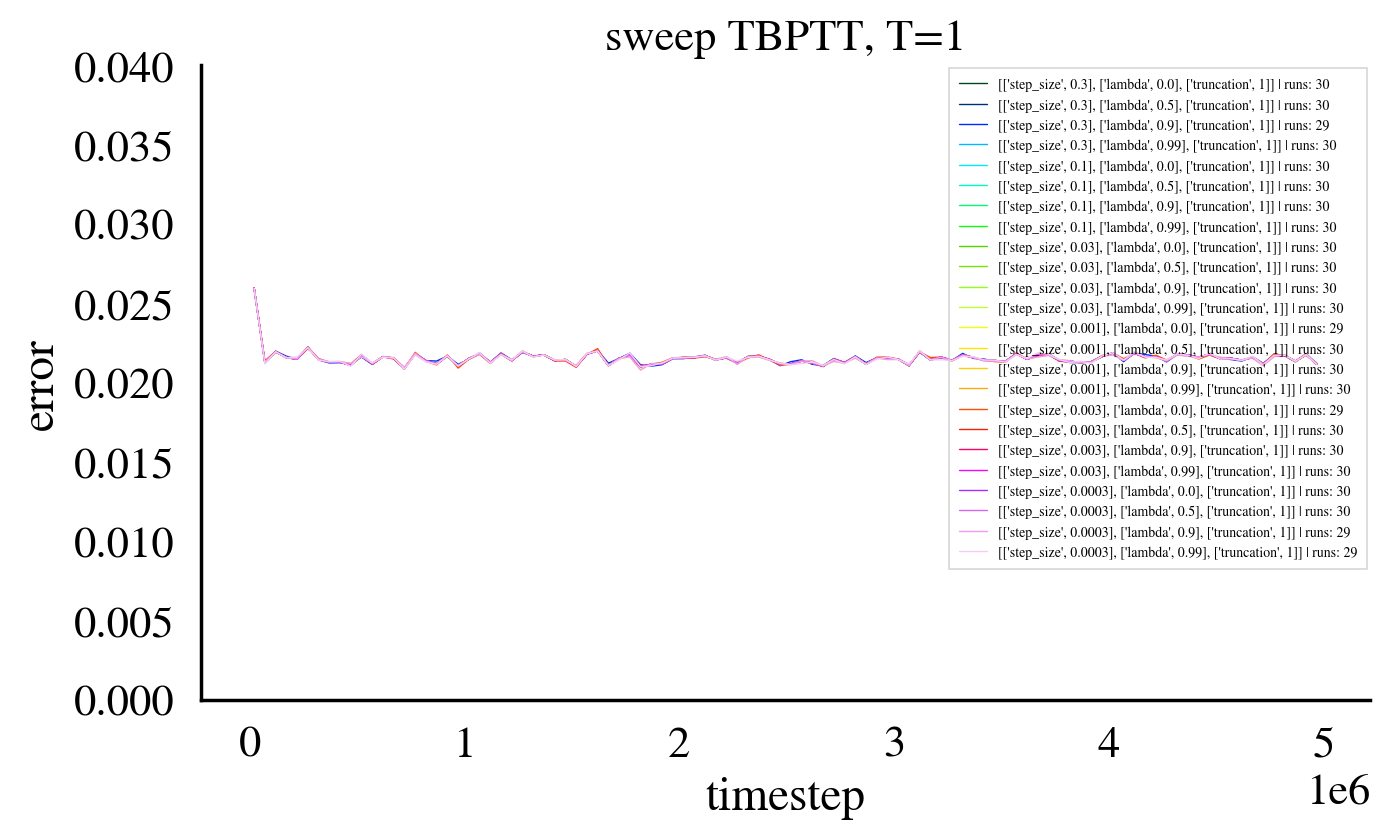

In [126]:
plt_name = f'sweep TBPTT, T=1'
fig = plt.figure(dpi=200)
plt.title(plt_name)
plt.xlabel('timestep')
plt.ylabel('error')

colors = plt.cycler(color=sns.color_palette("gist_ncar",  n_colors=24)).by_key()['color']
color_idx = 0

#conditions = [['step_size', 1e-1],
#             ['lambda', 0.9]]
for p in itertools.product(p2,p3):
    conditions = [['step_size', p[0]],
                  ['lambda', p[1]],
                  ['truncation', 1]]
    print("plotting: ", conditions)
    if plt_with_err("", 100, 4970000.0, db1, colors[color_idx], str(conditions), conditions, "error_table", False, pkey_col = "run", nocomment=True, linewidth=0.5):
        color_idx+=1

#plt.axhline(y=0.95, color='black', linestyle=':', linewidth=2, alpha=0.5)
plt.ylim(0, 0.05)
legend = plt.legend(prop={'size': 5})
frame = legend.get_frame()
#frame.set_edgecolor('black')
frame.set_linewidth(0.6)
frame.set_boxstyle('Square')
fig.axes[0].set_ylim(bottom=0, top=0.04)
fig.axes[0].set_yticks([0.0,0.005, 0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04])
plt.savefig('figure1.pdf', bbox_inches='tight')
plt.show()

plotting:  [['step_size', 0.3], ['lambda', 0.0], ['truncation', 10]]
	 Found 19 valid runs for [['step_size', 0.3], ['lambda', 0.0], ['truncation', 10]]
plotting:  [['step_size', 0.3], ['lambda', 0.5], ['truncation', 10]]
	 Found 18 valid runs for [['step_size', 0.3], ['lambda', 0.5], ['truncation', 10]]
plotting:  [['step_size', 0.3], ['lambda', 0.9], ['truncation', 10]]
	 Found 18 valid runs for [['step_size', 0.3], ['lambda', 0.9], ['truncation', 10]]
plotting:  [['step_size', 0.3], ['lambda', 0.99], ['truncation', 10]]
	 Found 18 valid runs for [['step_size', 0.3], ['lambda', 0.99], ['truncation', 10]]
plotting:  [['step_size', 0.1], ['lambda', 0.0], ['truncation', 10]]
	 Found 18 valid runs for [['step_size', 0.1], ['lambda', 0.0], ['truncation', 10]]
plotting:  [['step_size', 0.1], ['lambda', 0.5], ['truncation', 10]]
	 Found 18 valid runs for [['step_size', 0.1], ['lambda', 0.5], ['truncation', 10]]
plotting:  [['step_size', 0.1], ['lambda', 0.9], ['truncation', 10]]
	 Found 18 

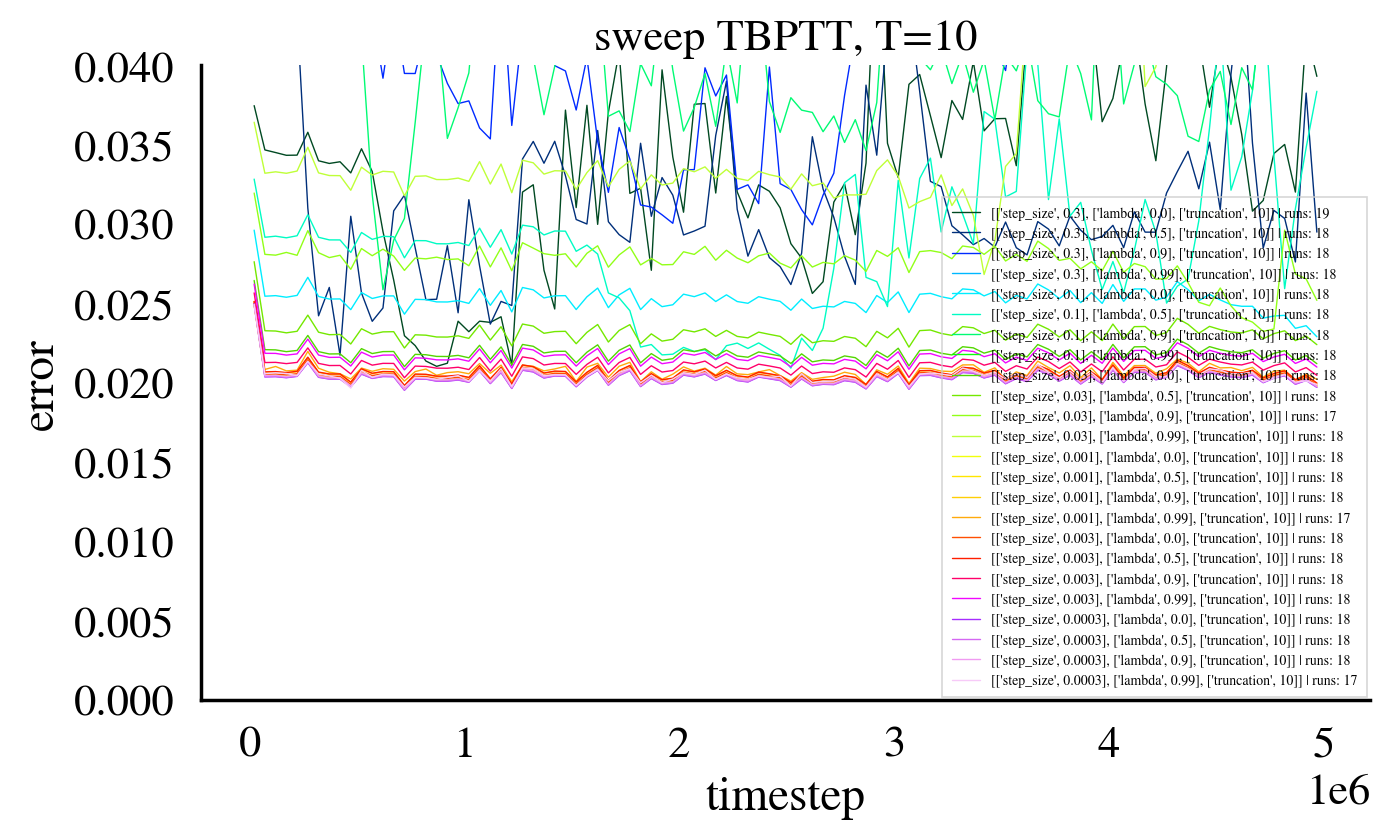

In [127]:
#pink is best
plt_name = f'sweep TBPTT, T=10'
fig = plt.figure(dpi=200)
plt.title(plt_name)
plt.xlabel('timestep')
plt.ylabel('error')

colors = plt.cycler(color=sns.color_palette("gist_ncar",  n_colors=24)).by_key()['color']
color_idx = 0

#conditions = [['step_size', 1e-1],
#             ['lambda', 0.9]]
for p in itertools.product(p2,p3):
    conditions = [['step_size', p[0]],
                  ['lambda', p[1]],
                  ['truncation', 10]]
    print("plotting: ", conditions)
    if plt_with_err("", 100, 4970000.0, db1, colors[color_idx], str(conditions), conditions, "error_table", False, pkey_col = "run", nocomment=True, linewidth=0.5):
        color_idx+=1

#plt.axhline(y=0.95, color='black', linestyle=':', linewidth=2, alpha=0.5)
plt.ylim(0, 0.05)
legend = plt.legend(prop={'size': 5})
frame = legend.get_frame()
#frame.set_edgecolor('black')
frame.set_linewidth(0.6)
frame.set_boxstyle('Square')
fig.axes[0].set_ylim(bottom=0, top=0.04)
fig.axes[0].set_yticks([0.0,0.005, 0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04])
plt.savefig('figure1.pdf', bbox_inches='tight')
plt.show()

plotting:  [['step_size', 0.3], ['lambda', 0.0], ['truncation', 27]]
	 Found 8 valid runs for [['step_size', 0.3], ['lambda', 0.0], ['truncation', 27]]
plotting:  [['step_size', 0.3], ['lambda', 0.5], ['truncation', 27]]
	 Found 8 valid runs for [['step_size', 0.3], ['lambda', 0.5], ['truncation', 27]]
plotting:  [['step_size', 0.3], ['lambda', 0.9], ['truncation', 27]]
	 Found 8 valid runs for [['step_size', 0.3], ['lambda', 0.9], ['truncation', 27]]
plotting:  [['step_size', 0.3], ['lambda', 0.99], ['truncation', 27]]
	 Found 8 valid runs for [['step_size', 0.3], ['lambda', 0.99], ['truncation', 27]]
plotting:  [['step_size', 0.1], ['lambda', 0.0], ['truncation', 27]]
	 Found 8 valid runs for [['step_size', 0.1], ['lambda', 0.0], ['truncation', 27]]
plotting:  [['step_size', 0.1], ['lambda', 0.5], ['truncation', 27]]
	 Found 8 valid runs for [['step_size', 0.1], ['lambda', 0.5], ['truncation', 27]]
plotting:  [['step_size', 0.1], ['lambda', 0.9], ['truncation', 27]]
	 Found 8 valid r

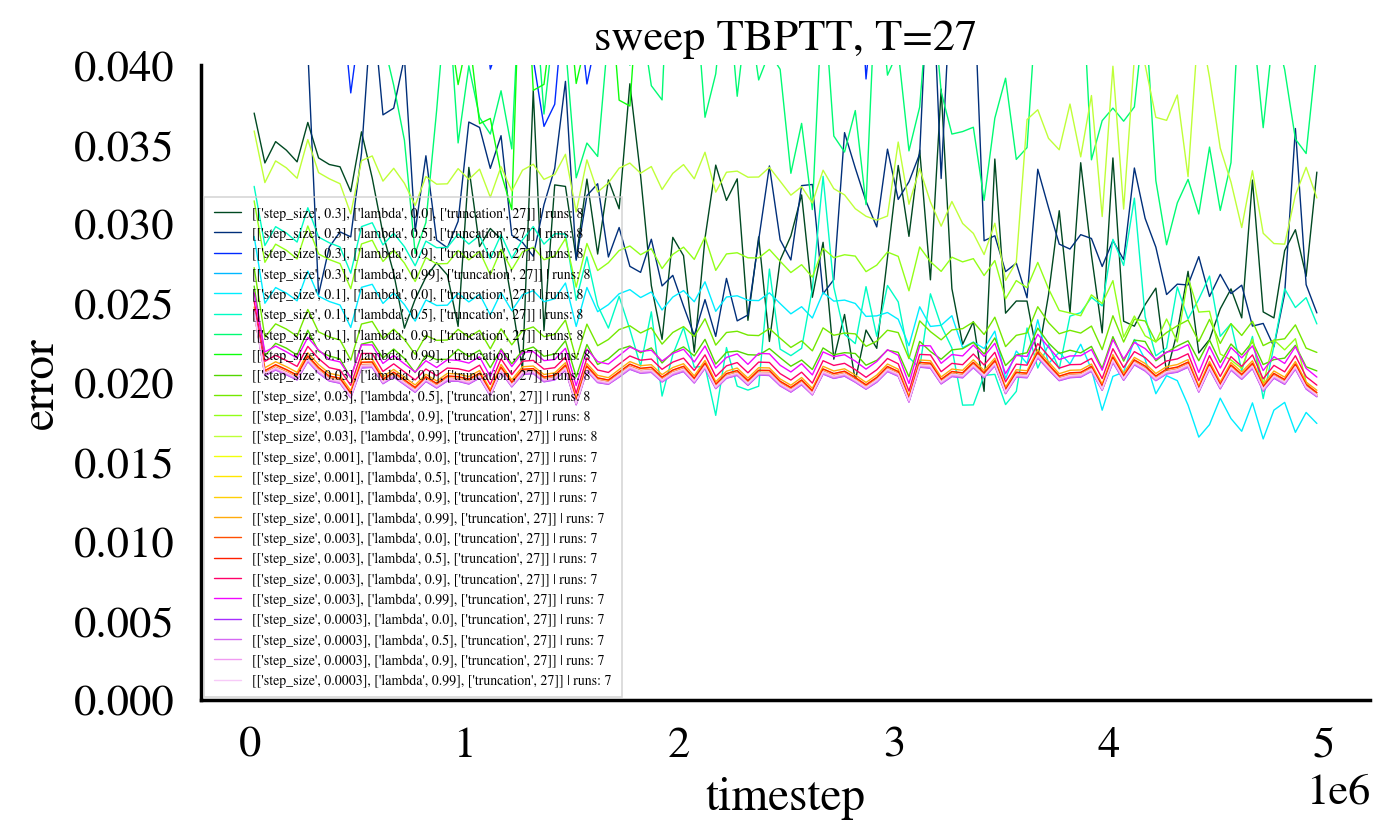

In [128]:
plt_name = f'sweep TBPTT, T=27'
fig = plt.figure(dpi=200)
plt.title(plt_name)
plt.xlabel('timestep')
plt.ylabel('error')

colors = plt.cycler(color=sns.color_palette("gist_ncar",  n_colors=24)).by_key()['color']
color_idx = 0

#conditions = [['step_size', 1e-1],
#             ['lambda', 0.9]]
for p in itertools.product(p2,p3):
    conditions = [['step_size', p[0]],
                  ['lambda', p[1]],
                  ['truncation', 27]]
    print("plotting: ", conditions)
    if plt_with_err("", 100, 4970000.0, db1, colors[color_idx], str(conditions), conditions, "error_table", False, pkey_col = "run", nocomment=True, linewidth=0.5):
        color_idx+=1

#plt.axhline(y=0.95, color='black', linestyle=':', linewidth=2, alpha=0.5)
plt.ylim(0, 0.05)
legend = plt.legend(prop={'size': 5})
frame = legend.get_frame()
#frame.set_edgecolor('black')
frame.set_linewidth(0.6)
frame.set_boxstyle('Square')
fig.axes[0].set_ylim(bottom=0, top=0.04)
fig.axes[0].set_yticks([0.0,0.005, 0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04])
plt.savefig('figure1.pdf', bbox_inches='tight')
plt.show()

plotting:  [['step_size', 0.3], ['lambda', 0.0], ['truncation', 50]]
	 Found 5 valid runs for [['step_size', 0.3], ['lambda', 0.0], ['truncation', 50]]
plotting:  [['step_size', 0.3], ['lambda', 0.5], ['truncation', 50]]
	 Found 4 valid runs for [['step_size', 0.3], ['lambda', 0.5], ['truncation', 50]]
plotting:  [['step_size', 0.3], ['lambda', 0.9], ['truncation', 50]]
	 Found 4 valid runs for [['step_size', 0.3], ['lambda', 0.9], ['truncation', 50]]
plotting:  [['step_size', 0.3], ['lambda', 0.99], ['truncation', 50]]
	 Found 4 valid runs for [['step_size', 0.3], ['lambda', 0.99], ['truncation', 50]]
plotting:  [['step_size', 0.1], ['lambda', 0.0], ['truncation', 50]]
	 Found 4 valid runs for [['step_size', 0.1], ['lambda', 0.0], ['truncation', 50]]
plotting:  [['step_size', 0.1], ['lambda', 0.5], ['truncation', 50]]
	 Found 4 valid runs for [['step_size', 0.1], ['lambda', 0.5], ['truncation', 50]]
plotting:  [['step_size', 0.1], ['lambda', 0.9], ['truncation', 50]]
	 Found 4 valid r

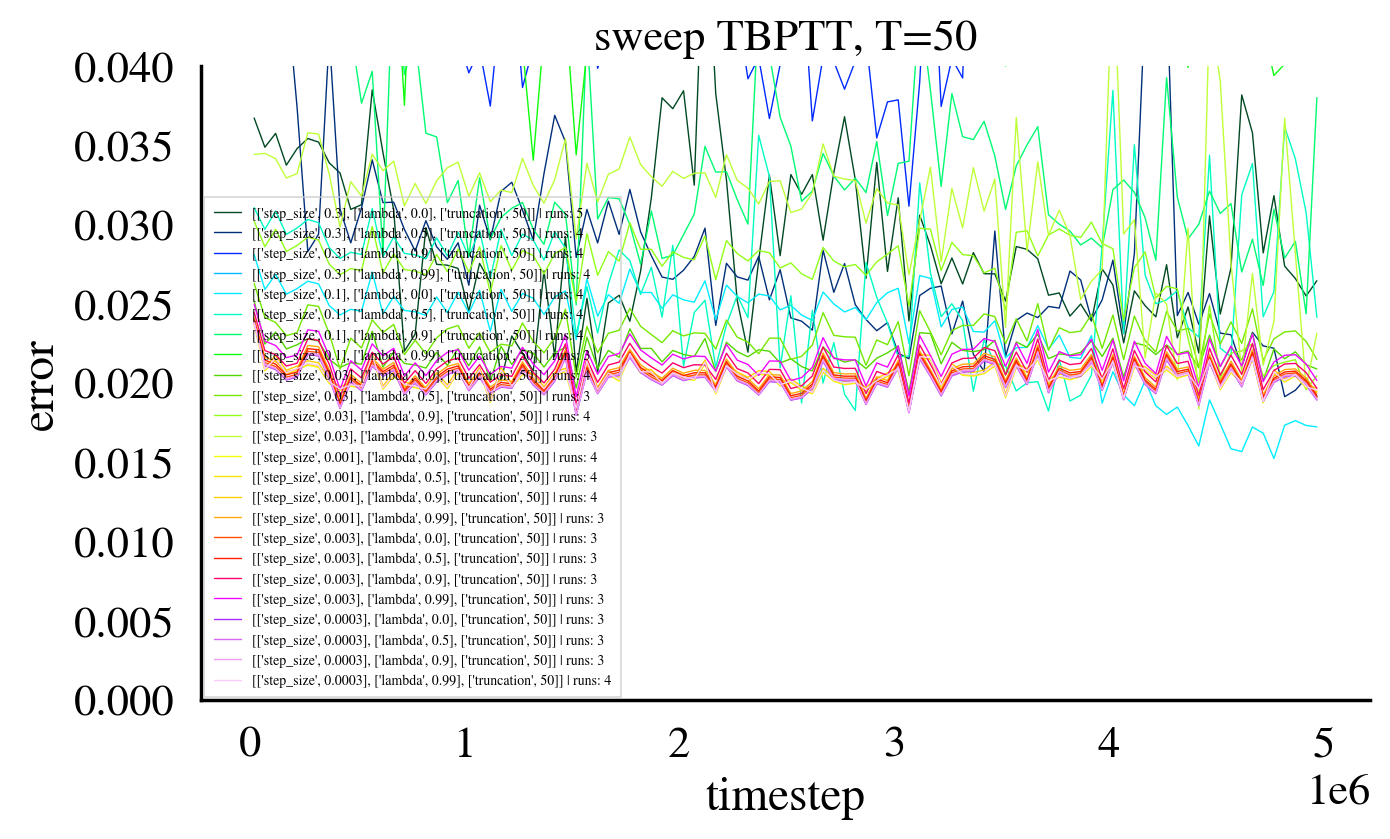

In [129]:
plt_name = f'sweep TBPTT, T=50'
fig = plt.figure(dpi=200)
plt.title(plt_name)
plt.xlabel('timestep')
plt.ylabel('error')

colors = plt.cycler(color=sns.color_palette("gist_ncar",  n_colors=24)).by_key()['color']
color_idx = 0

#conditions = [['step_size', 1e-1],
#             ['lambda', 0.9]]
for p in itertools.product(p2,p3):
    conditions = [['step_size', p[0]],
                  ['lambda', p[1]],
                  ['truncation', 50]]
    print("plotting: ", conditions)
    if plt_with_err("", 100, 4970000.0, db1, colors[color_idx], str(conditions), conditions, "error_table", False, pkey_col = "run", nocomment=True, linewidth=0.5):
        color_idx+=1

#plt.axhline(y=0.015, color='black', linestyle=':', linewidth=2, alpha=0.5)
#plt.ylim(0, 0.015)
legend = plt.legend(prop={'size': 5})
frame = legend.get_frame()
#frame.set_edgecolor('black')
frame.set_linewidth(0.6)
frame.set_boxstyle('Square')
fig.axes[0].set_ylim(bottom=0, top=0.04)
fig.axes[0].set_yticks([0.0,0.005, 0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04])
plt.savefig('figure1.pdf', bbox_inches='tight')
plt.show()

plotting:  [['step_size', 0.3], ['lambda', 0.0]]
	 Found 3 valid runs for [['step_size', 0.3], ['lambda', 0.0]]
plotting:  [['step_size', 0.3], ['lambda', 0.5]]
	 Found 3 valid runs for [['step_size', 0.3], ['lambda', 0.5]]
plotting:  [['step_size', 0.3], ['lambda', 0.9]]
	 Found 3 valid runs for [['step_size', 0.3], ['lambda', 0.9]]
plotting:  [['step_size', 0.3], ['lambda', 0.99]]
	 Found 3 valid runs for [['step_size', 0.3], ['lambda', 0.99]]
plotting:  [['step_size', 0.1], ['lambda', 0.0]]
	 Found 3 valid runs for [['step_size', 0.1], ['lambda', 0.0]]
plotting:  [['step_size', 0.1], ['lambda', 0.5]]
	 Found 3 valid runs for [['step_size', 0.1], ['lambda', 0.5]]
plotting:  [['step_size', 0.1], ['lambda', 0.9]]
	 Found 3 valid runs for [['step_size', 0.1], ['lambda', 0.9]]
plotting:  [['step_size', 0.1], ['lambda', 0.99]]
	 Found 3 valid runs for [['step_size', 0.1], ['lambda', 0.99]]
plotting:  [['step_size', 0.03], ['lambda', 0.0]]
	 Found 3 valid runs for [['step_size', 0.03], ['l

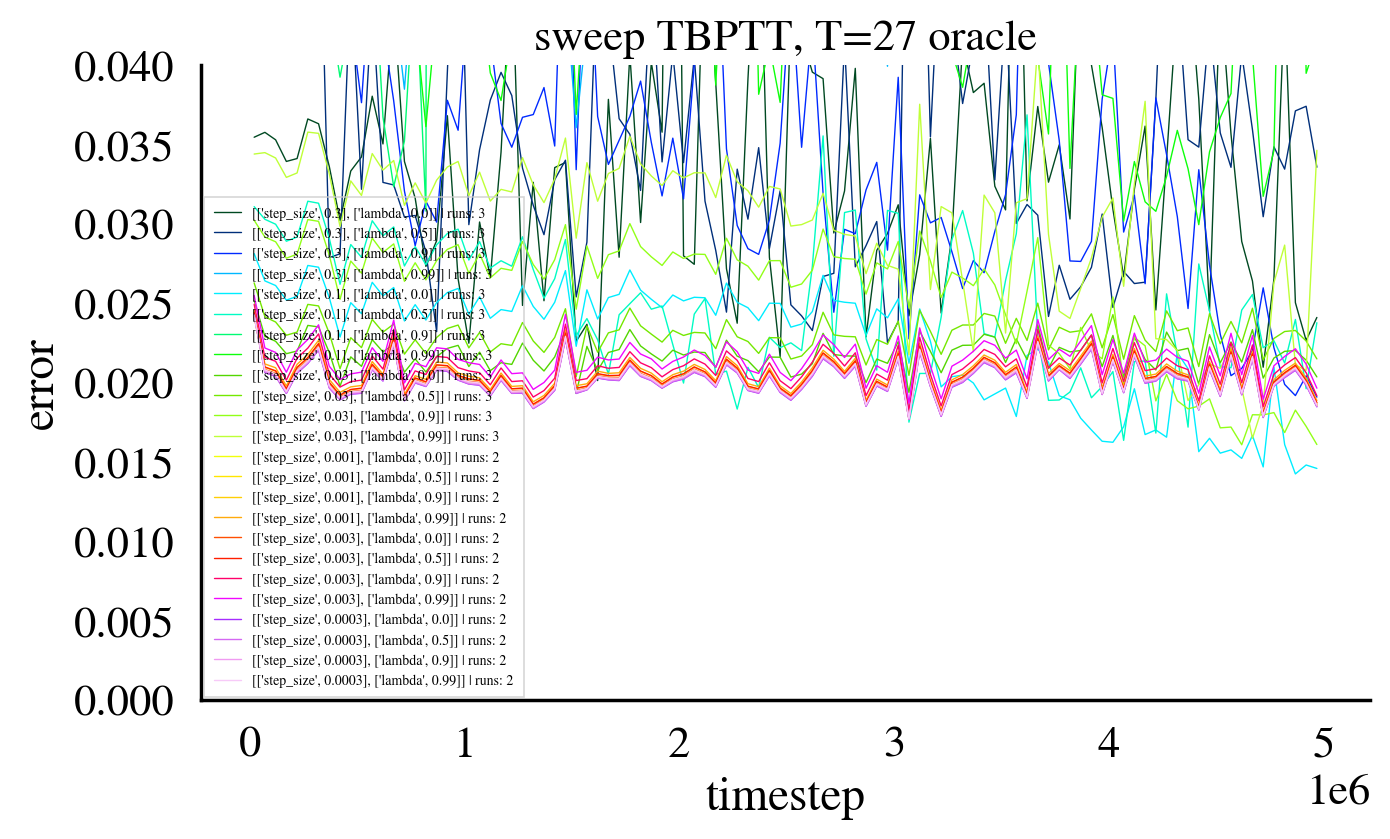

In [141]:
plt_name = f'sweep TBPTT, T=27 oracle'
fig = plt.figure(dpi=200)
plt.title(plt_name)
plt.xlabel('timestep')
plt.ylabel('error')

colors = plt.cycler(color=sns.color_palette("gist_ncar",  n_colors=24)).by_key()['color']
color_idx = 0

for p in itertools.product(p2,p3):
    conditions = [['step_size', p[0]],
                  ['lambda', p[1]]]
    print("plotting: ", conditions)
    if plt_with_err("", 100, 4970000.0, db3, colors[color_idx], str(conditions), conditions, "error_table", False, pkey_col = "run", nocomment=True, linewidth=0.5):
        color_idx+=1

#plt.axhline(y=0.015, color='black', linestyle=':', linewidth=2, alpha=0.5)
#plt.ylim(0, 0.015)
legend = plt.legend(prop={'size': 5})
frame = legend.get_frame()
#frame.set_edgecolor('black')
frame.set_linewidth(0.6)
frame.set_boxstyle('Square')
fig.axes[0].set_ylim(bottom=0, top=0.04)
fig.axes[0].set_yticks([0.0,0.005, 0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04])
plt.savefig('figure1.pdf', bbox_inches='tight')
plt.show()

# Comparing lambdas for best step_size

plotting:  [['step_size', 0.0003], ['lambda', 0.0], ['truncation', 10]]
	 Found 18 valid runs for [['step_size', 0.0003], ['lambda', 0.0], ['truncation', 10]]
plotting:  [['step_size', 0.0003], ['lambda', 0.5], ['truncation', 10]]
	 Found 18 valid runs for [['step_size', 0.0003], ['lambda', 0.5], ['truncation', 10]]
plotting:  [['step_size', 0.0003], ['lambda', 0.9], ['truncation', 10]]
	 Found 18 valid runs for [['step_size', 0.0003], ['lambda', 0.9], ['truncation', 10]]
plotting:  [['step_size', 0.0003], ['lambda', 0.99], ['truncation', 10]]
	 Found 17 valid runs for [['step_size', 0.0003], ['lambda', 0.99], ['truncation', 10]]


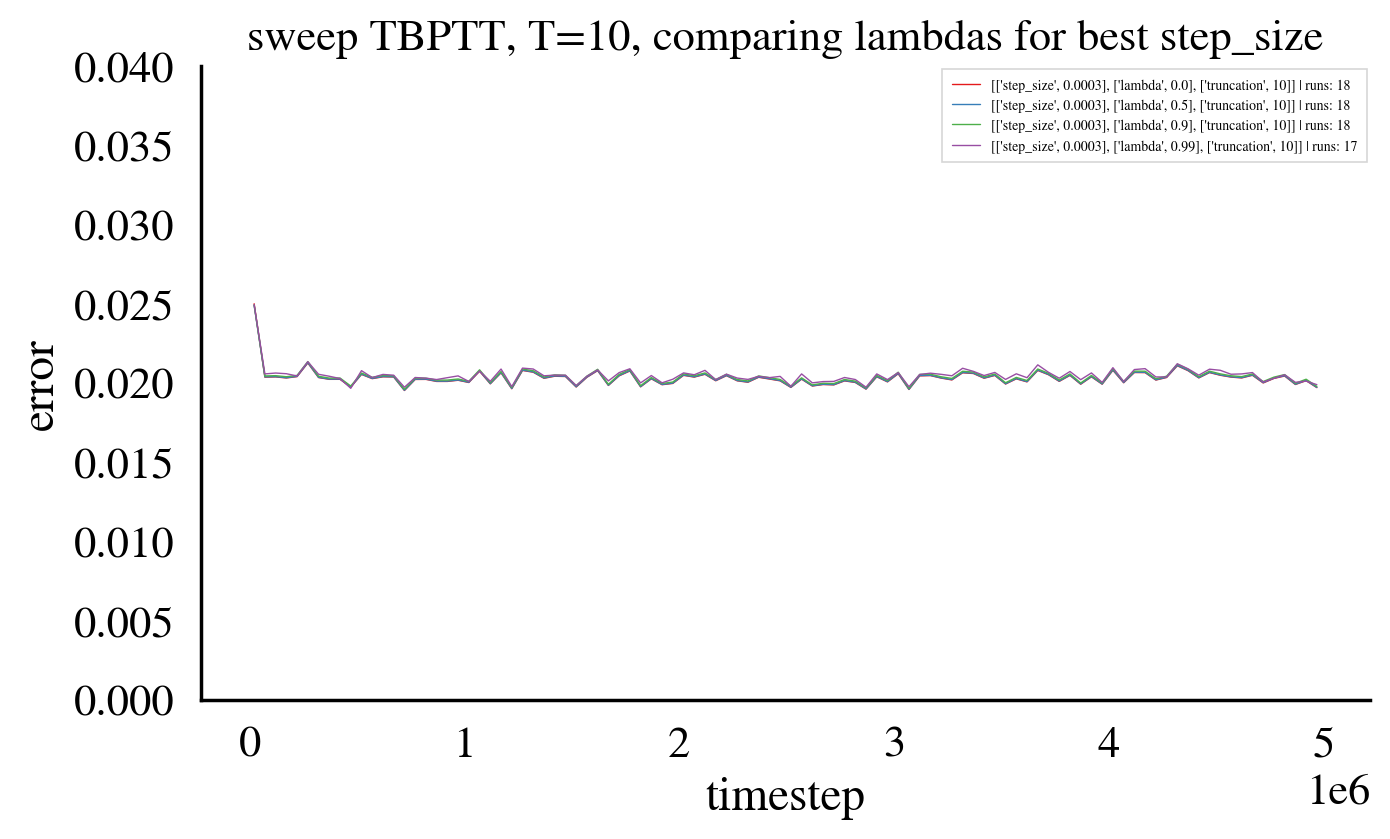

In [151]:
plt_name = f'sweep TBPTT, T=10, comparing lambdas for best step_size'
fig = plt.figure(dpi=200)
plt.title(plt_name)
plt.xlabel('timestep')
plt.ylabel('error')

colors = plt.cycler(color=sns.color_palette("Set1",  n_colors=4)).by_key()['color']
color_idx = 0

#conditions = [['step_size', 1e-1],
#             ['lambda', 0.9]]
for p in itertools.product(p2,p3):
    conditions = [['step_size', p[0]],
                  ['lambda', p[1]],
                  ['truncation', 10]]
    if conditions[0][1] != 0.0003:
        continue
    print("plotting: ", conditions)
    if plt_with_err("", 100, 4970000.0, db1, colors[color_idx], str(conditions), conditions, "error_table", False, pkey_col = "run", nocomment=True, linewidth=0.5):
        color_idx+=1

#plt.axhline(y=0.95, color='black', linestyle=':', linewidth=2, alpha=0.5)
plt.ylim(0, 0.05)
legend = plt.legend(prop={'size': 5})
frame = legend.get_frame()
#frame.set_edgecolor('black')
frame.set_linewidth(0.6)
frame.set_boxstyle('Square')
fig.axes[0].set_ylim(bottom=0, top=0.04)
fig.axes[0].set_yticks([0.0,0.005, 0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04])
plt.savefig('figure1.pdf', bbox_inches='tight')
plt.show()

plotting:  [['width', 20], ['lambda', 0], ['step_size', 0.3], ['freq', 800000]]
	 Found 30 valid runs for [['width', 20], ['lambda', 0], ['step_size', 0.3], ['freq', 800000]]
plotting:  [['width', 20], ['lambda', 0.5], ['step_size', 0.3], ['freq', 800000]]
	 Found 30 valid runs for [['width', 20], ['lambda', 0.5], ['step_size', 0.3], ['freq', 800000]]
plotting:  [['width', 20], ['lambda', 0.9], ['step_size', 0.03], ['freq', 800000]]
	 Found 30 valid runs for [['width', 20], ['lambda', 0.9], ['step_size', 0.03], ['freq', 800000]]
plotting:  [['width', 20], ['lambda', 0.99], ['step_size', 0.01], ['freq', 800000]]
	 Found 30 valid runs for [['width', 20], ['lambda', 0.99], ['step_size', 0.01], ['freq', 800000]]


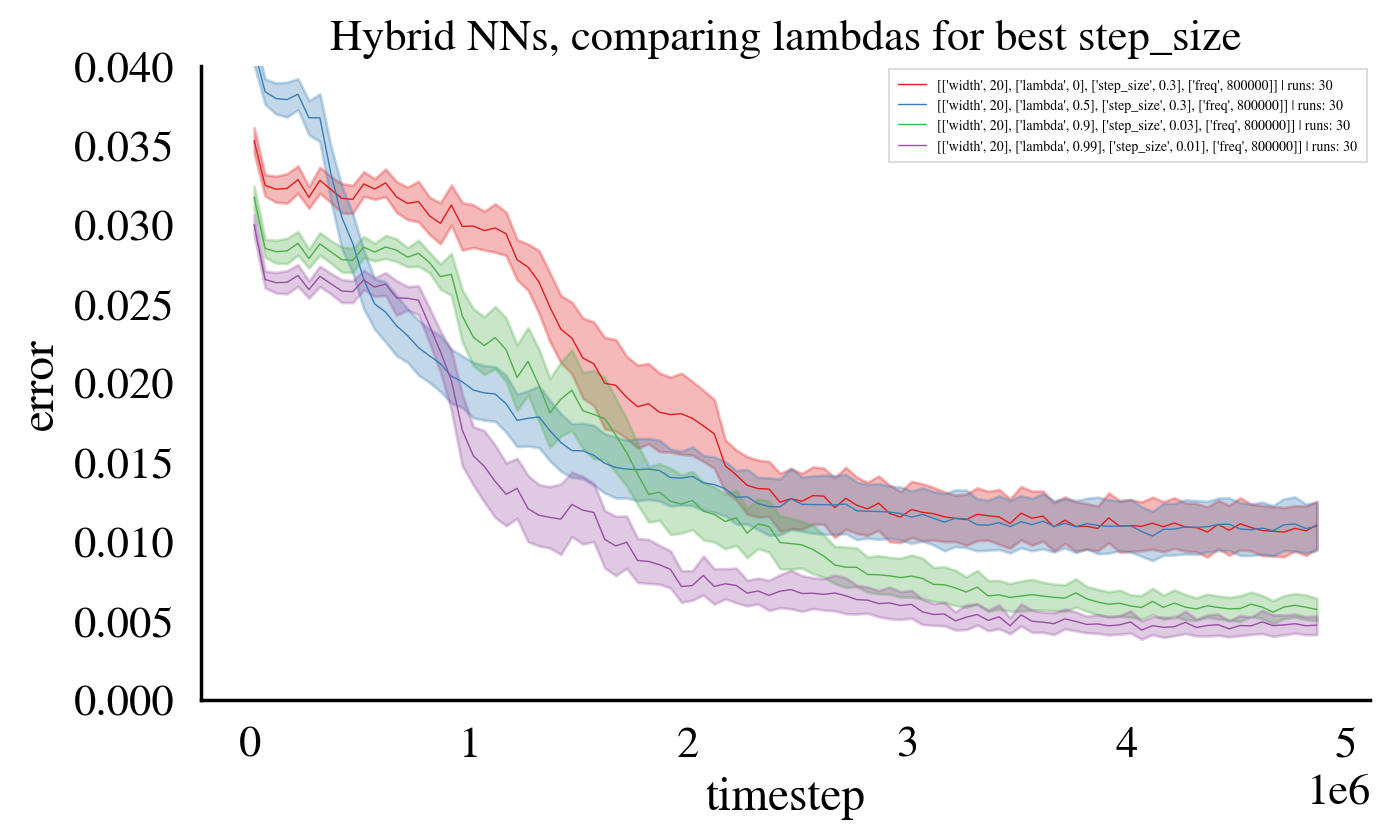

In [326]:
plt_name = f'Hybrid NNs, comparing lambdas for best step_size'
fig = plt.figure(dpi=200)
plt.title(plt_name)
plt.xlabel('timestep')
plt.ylabel('error')

colors = plt.cycler(color=sns.color_palette("Set1",  n_colors=4)).by_key()['color']
color_idx = 0

lambdas = pd.read_sql(f'select distinct(lambda) from runs', db2.conn).values.squeeze()


conditions = [['width', 20],
             ['lambda', 0],
             ['step_size', 3e-1],
             ['freq', 800000]]
    
print("plotting: ", conditions)
if plt_with_err("", 98, 4500000, db2, colors[color_idx], str(conditions), conditions, "error_table", True, pkey_col = "run", nocomment=True, linewidth=0.5):
    color_idx+=1

conditions = [['width', 20],
             ['lambda', 0.5],
             ['step_size', 3e-1],
             ['freq', 800000]]
    
print("plotting: ", conditions)
if plt_with_err("", 98, 4500000, db2, colors[color_idx], str(conditions), conditions, "error_table", True, pkey_col = "run", nocomment=True, linewidth=0.5):
    color_idx+=1
    
conditions = [['width', 20],
             ['lambda', 0.9],
             ['step_size', 3e-2],
             ['freq', 800000]]
    
print("plotting: ", conditions)
if plt_with_err("", 98, 4500000, db2, colors[color_idx], str(conditions), conditions, "error_table", True, pkey_col = "run", nocomment=True, linewidth=0.5):
    color_idx+=1
    
conditions = [['width', 20],
             ['lambda', 0.99],
             ['step_size', 1e-2],
             ['freq', 800000]]
    
print("plotting: ", conditions)
if plt_with_err("", 98, 4500000, db2, colors[color_idx], str(conditions), conditions, "error_table", True, pkey_col = "run", nocomment=True, linewidth=0.5):
    color_idx+=1
    
#plt.axhline(y=0.015, color='black', linestyle=':', linewidth=2, alpha=0.5)
#plt.ylim(0, 0.015)
legend = plt.legend(prop={'size': 5})
frame = legend.get_frame()
#frame.set_edgecolor('black')
frame.set_linewidth(0.6)
frame.set_boxstyle('Square')
fig.axes[0].set_ylim(bottom=0, top=0.04)
fig.axes[0].set_yticks([0.0,0.005, 0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04])
plt.savefig('figure1.pdf', bbox_inches='tight')
plt.show()

plotting:  [['width', 1], ['lambda', 0], ['step_size', 0.003], ['freq', 400000]]
	 Found 30 valid runs for [['width', 1], ['lambda', 0], ['step_size', 0.003], ['freq', 400000]]
plotting:  [['width', 1], ['lambda', 0.5], ['step_size', 0.1], ['freq', 400000]]
	 Found 30 valid runs for [['width', 1], ['lambda', 0.5], ['step_size', 0.1], ['freq', 400000]]
plotting:  [['width', 1], ['lambda', 0.9], ['step_size', 0.03], ['freq', 400000]]
	 Found 30 valid runs for [['width', 1], ['lambda', 0.9], ['step_size', 0.03], ['freq', 400000]]
plotting:  [['width', 1], ['lambda', 0.99], ['step_size', 0.01], ['freq', 400000]]
	 Found 30 valid runs for [['width', 1], ['lambda', 0.99], ['step_size', 0.01], ['freq', 400000]]


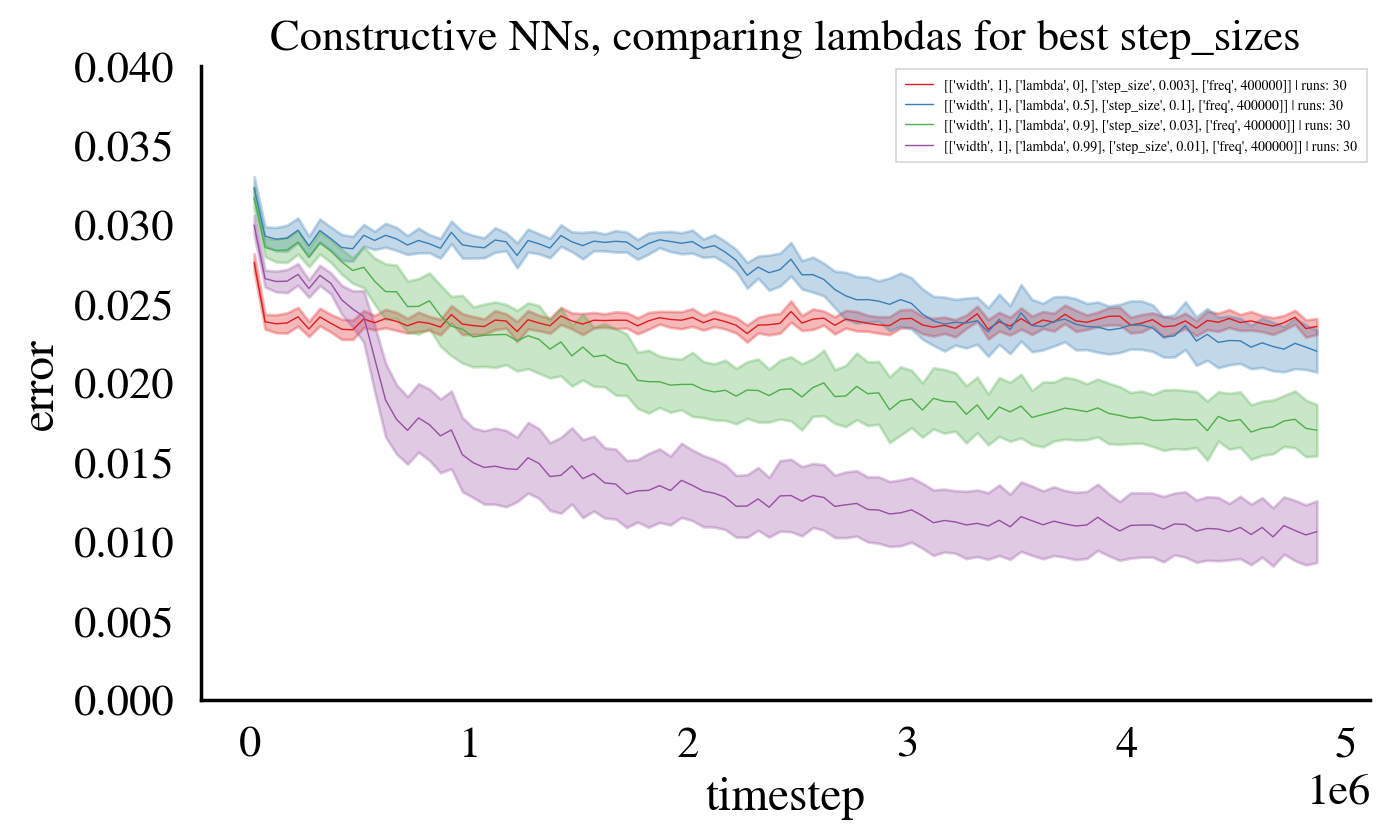

In [335]:
plt_name = f'Constructive NNs, comparing lambdas for best step_sizes'
fig = plt.figure(dpi=200)
plt.title(plt_name)
plt.xlabel('timestep')
plt.ylabel('error')

colors = plt.cycler(color=sns.color_palette("Set1",  n_colors=4)).by_key()['color']
color_idx = 0

lambdas = pd.read_sql(f'select distinct(lambda) from runs', db2.conn).values.squeeze()


conditions = [['width', 1],
             ['lambda', 0],
             ['step_size', 3e-3],
             ['freq', 400000]]
    
print("plotting: ", conditions)
if plt_with_err("", 98, 4500000, db2, colors[color_idx], str(conditions), conditions, "error_table", True, pkey_col = "run", nocomment=True, linewidth=0.5):
    color_idx+=1

conditions = [['width', 1],
             ['lambda', 0.5],
             ['step_size', 1e-1],
             ['freq', 400000]]
    
print("plotting: ", conditions)
if plt_with_err("", 98, 4500000, db2, colors[color_idx], str(conditions), conditions, "error_table", True, pkey_col = "run", nocomment=True, linewidth=0.5):
    color_idx+=1
    
conditions = [['width', 1],
             ['lambda', 0.9],
             ['step_size', 3e-2],
             ['freq', 400000]]
    
print("plotting: ", conditions)
if plt_with_err("", 98, 4500000, db2, colors[color_idx], str(conditions), conditions, "error_table", True, pkey_col = "run", nocomment=True, linewidth=0.5):
    color_idx+=1
    
conditions = [['width', 1],
             ['lambda', 0.99],
             ['step_size', 1e-2],
             ['freq', 400000]]
    
print("plotting: ", conditions)
if plt_with_err("", 98, 4500000, db2, colors[color_idx], str(conditions), conditions, "error_table", True, pkey_col = "run", nocomment=True, linewidth=0.5):
    color_idx+=1
    
#plt.axhline(y=0.015, color='black', linestyle=':', linewidth=2, alpha=0.5)
#plt.ylim(0, 0.015)
legend = plt.legend(prop={'size': 5})
frame = legend.get_frame()
#frame.set_edgecolor('black')
frame.set_linewidth(0.6)
frame.set_boxstyle('Square')
fig.axes[0].set_ylim(bottom=0, top=0.04)
fig.axes[0].set_yticks([0.0,0.005, 0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04])
plt.savefig('figure1.pdf', bbox_inches='tight')
plt.show()

In [352]:
lambdas

array(['6e-1', '3e-1', '1e-1', '3e-2', '1e-2', '3e-3'], dtype=object)

plotting:  [['width', 200], ['lambda', 0], ['step_size', 0.6]]
	 Found 30 valid runs for [['width', 200], ['lambda', 0], ['step_size', 0.6]]
plotting:  [['width', 200], ['lambda', 0.5], ['step_size', 0.3]]
	 Found 30 valid runs for [['width', 200], ['lambda', 0.5], ['step_size', 0.3]]
plotting:  [['width', 200], ['lambda', 0.9], ['step_size', 0.1]]
	 Found 30 valid runs for [['width', 200], ['lambda', 0.9], ['step_size', 0.1]]
plotting:  [['width', 200], ['lambda', 0.99], ['step_size', 0.03]]
	 Found 30 valid runs for [['width', 200], ['lambda', 0.99], ['step_size', 0.03]]


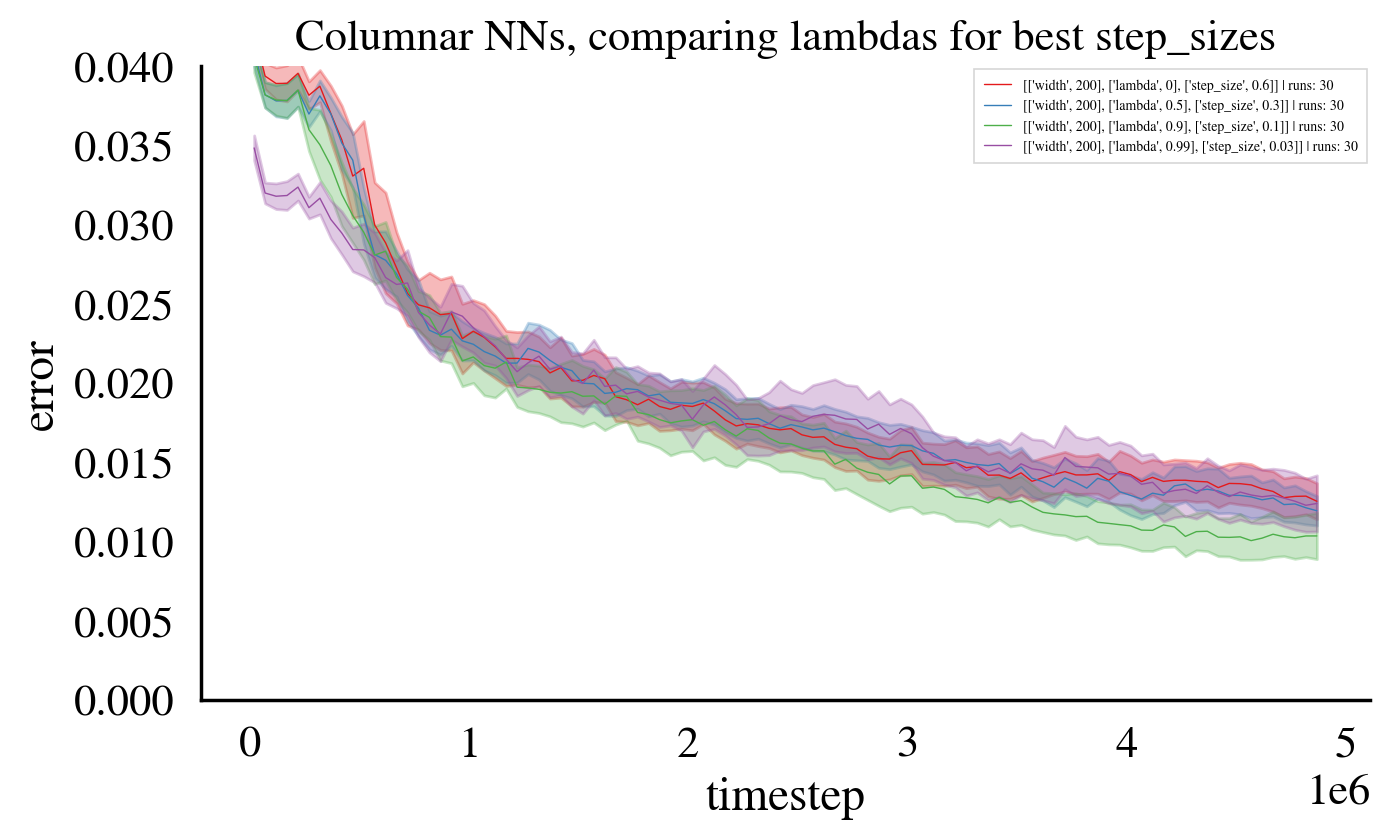

In [347]:
plt_name = f'Columnar NNs, comparing lambdas for best step_sizes'
fig = plt.figure(dpi=200)
plt.title(plt_name)
plt.xlabel('timestep')
plt.ylabel('error')

colors = plt.cycler(color=sns.color_palette("Set1",  n_colors=4)).by_key()['color']
color_idx = 0

lambdas = pd.read_sql(f'select distinct(lambda) from runs', db2.conn).values.squeeze()


conditions = [['width', 200],
             ['lambda', 0],
             ['step_size', 6e-1]]
    
print("plotting: ", conditions)
if plt_with_err("", 98, 4500000, db2, colors[color_idx], str(conditions), conditions, "error_table", True, pkey_col = "run", nocomment=True, linewidth=0.5):
    color_idx+=1

conditions = [['width', 200],
             ['lambda', 0.5],
             ['step_size', 3e-1]]
    
print("plotting: ", conditions)
if plt_with_err("", 98, 4500000, db2, colors[color_idx], str(conditions), conditions, "error_table", True, pkey_col = "run", nocomment=True, linewidth=0.5):
    color_idx+=1
    
conditions = [['width', 200],
             ['lambda', 0.9],
             ['step_size', 1e-1]]
    
print("plotting: ", conditions)
if plt_with_err("", 98, 4500000, db2, colors[color_idx], str(conditions), conditions, "error_table", True, pkey_col = "run", nocomment=True, linewidth=0.5):
    color_idx+=1
    
conditions = [['width', 200],
             ['lambda', 0.99],
             ['step_size', 3e-2]]
    
print("plotting: ", conditions)
if plt_with_err("", 98, 4500000, db2, colors[color_idx], str(conditions), conditions, "error_table", True, pkey_col = "run", nocomment=True, linewidth=0.5):
    color_idx+=1
    
#plt.axhline(y=0.015, color='black', linestyle=':', linewidth=2, alpha=0.5)
#plt.ylim(0, 0.015)
legend = plt.legend(prop={'size': 5})
frame = legend.get_frame()
#frame.set_edgecolor('black')
frame.set_linewidth(0.6)
frame.set_boxstyle('Square')
fig.axes[0].set_ylim(bottom=0, top=0.04)
fig.axes[0].set_yticks([0.0,0.005, 0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04])
plt.savefig('figure1.pdf', bbox_inches='tight')
plt.show()

# Combined comparison plot
not all runs included yet

	 Found 30 valid runs for [['step_size', 0.003], ['lambda', 0.99], ['truncation', 1]]
	 Found 22 valid runs for [['step_size', 0.0003], ['lambda', 0.5], ['truncation', 10]]
	 Found 10 valid runs for [['step_size', 0.1], ['lambda', 0.0], ['truncation', 27]]
	 Found 5 valid runs for [['step_size', 0.1], ['lambda', 0.0], ['truncation', 50]]
	 Found 3 valid runs for [['step_size', 0.1], ['lambda', 0.0], ['truncation', 27]]
	 Found 30 valid runs for [['width', 200], ['lambda', 0.9], ['step_size', 0.1]]
	 Found 30 valid runs for [['width', 1], ['lambda', 0.99], ['step_size', 0.01], ['freq', 400000]]
	 Found 30 valid runs for [['width', 20], ['lambda', 0.99], ['step_size', 0.01], ['freq', 800000]]


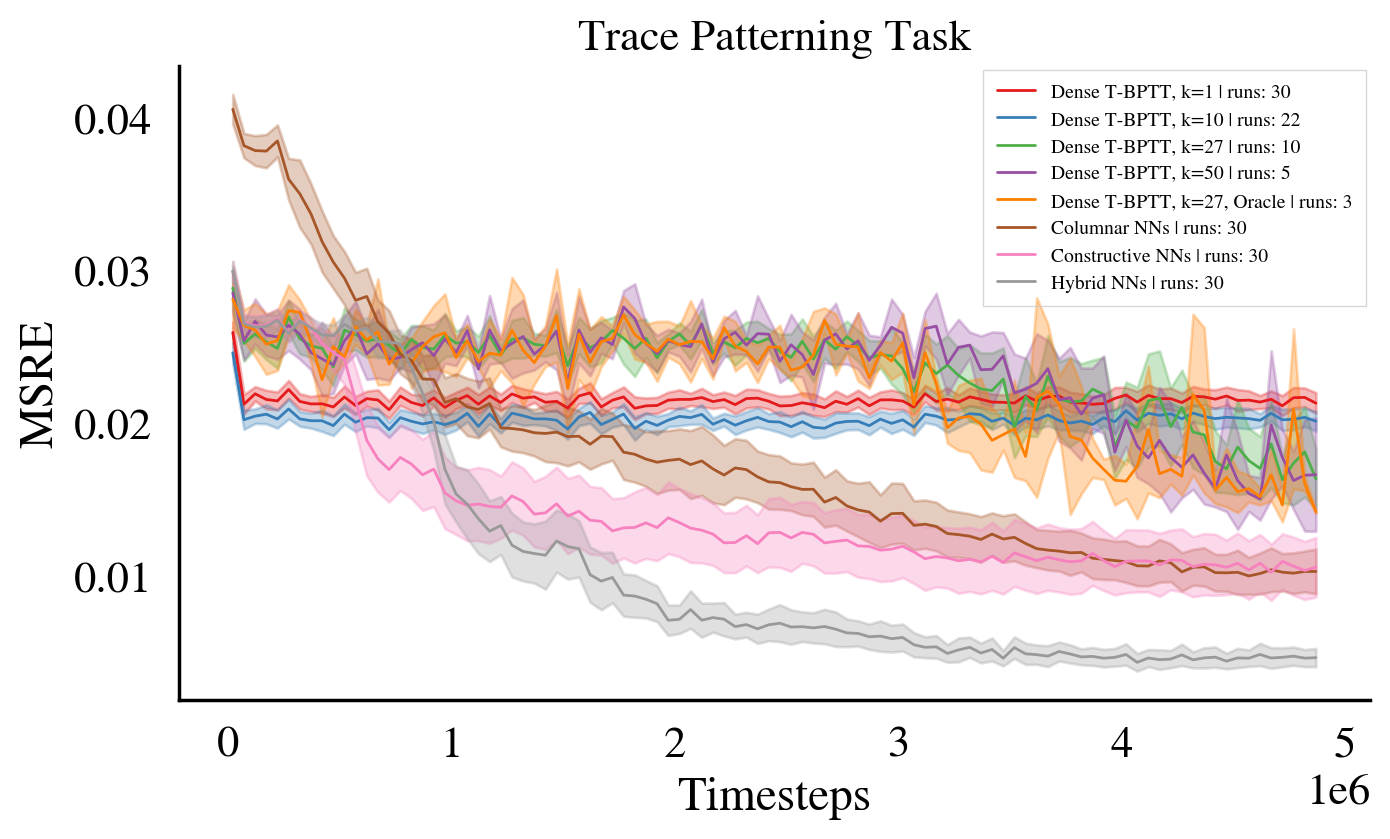

In [357]:
#TODO is this really MSRE or TD err in tables? check again
plt_name = f'Trace Patterning Task'
fig = plt.figure(dpi=200)
plt.title(plt_name)
plt.xlabel('Timesteps')
plt.ylabel('MSRE')

colors = plt.cycler(color=sns.color_palette("Set1", n_colors=9)).by_key()['color']
color_idx = 0

conditions = [['step_size', 0.003],
              ['lambda', 0.99],
              ['truncation', 1]]
plt_with_err("", 98, 4500000, db1, colors[color_idx], "Dense T-BPTT, k=1", conditions, "error_table", True, pkey_col = "run", nocomment=True, linewidth=1)
color_idx+=1

conditions = [['step_size', 0.0003],
              ['lambda', 0.5],
              ['truncation', 10]]
plt_with_err("", 98, 4500000, db1, colors[color_idx], "Dense T-BPTT, k=10", conditions, "error_table", True, pkey_col = "run", nocomment=True, linewidth=1)
color_idx+=1

conditions = [['step_size', 0.1],
              ['lambda', 0.0],
              ['truncation', 27]]
plt_with_err("", 98, 4500000, db1, colors[color_idx], "Dense T-BPTT, k=27", conditions, "error_table", True, pkey_col = "run", nocomment=True, linewidth=1)
color_idx+=1

conditions = [['step_size', 0.1],
              ['lambda', 0.0],
              ['truncation', 50]]
plt_with_err("", 98, 4500000, db1, colors[color_idx], "Dense T-BPTT, k=50", conditions, "error_table", True, pkey_col = "run", nocomment=True, linewidth=1)
color_idx+=1


conditions = [['step_size', 0.1],
              ['lambda', 0.0],
              ['truncation', 27]]
plt_with_err("", 98, 4500000, db3, colors[color_idx], "Dense T-BPTT, k=27, Oracle", conditions, "error_table", True, pkey_col = "run", nocomment=True, linewidth=1)
color_idx+=2

conditions = [['width', 200],
             ['lambda', 0.9],
             ['step_size', 0.1]]
plt_with_err("", 98, 4500000, db2, colors[color_idx], "Columnar NNs", conditions, "error_table", True, pkey_col = "run", nocomment=True, linewidth=1)
color_idx+=1

conditions = [['width', 1],
             ['lambda', 0.99],
             ['step_size', 1e-2],
             ['freq', 400000]]
plt_with_err("", 98, 4500000, db2, colors[color_idx], "Constructive NNs", conditions, "error_table", True, pkey_col = "run", nocomment=True, linewidth=1)
color_idx+=1

conditions = [['width', 20],
             ['lambda', 0.99],
             ['step_size', 1e-2],
             ['freq', 800000]]
plt_with_err("", 98, 4500000, db2, colors[color_idx], "Hybrid NNs", conditions, "error_table", True, pkey_col = "run", nocomment=True, linewidth=1)
color_idx+=1

#plt.axhline(y=0.95, color='black', linestyle=':', linewidth=2, alpha=0.5)
legend = plt.legend(prop={'size': 7})
frame = legend.get_frame()
#frame.set_edgecolor('black')
frame.set_linewidth(0.5)
frame.set_boxstyle('Square')
plt.savefig('figures/plt_animal.pdf', bbox_inches='tight')
plt.show()

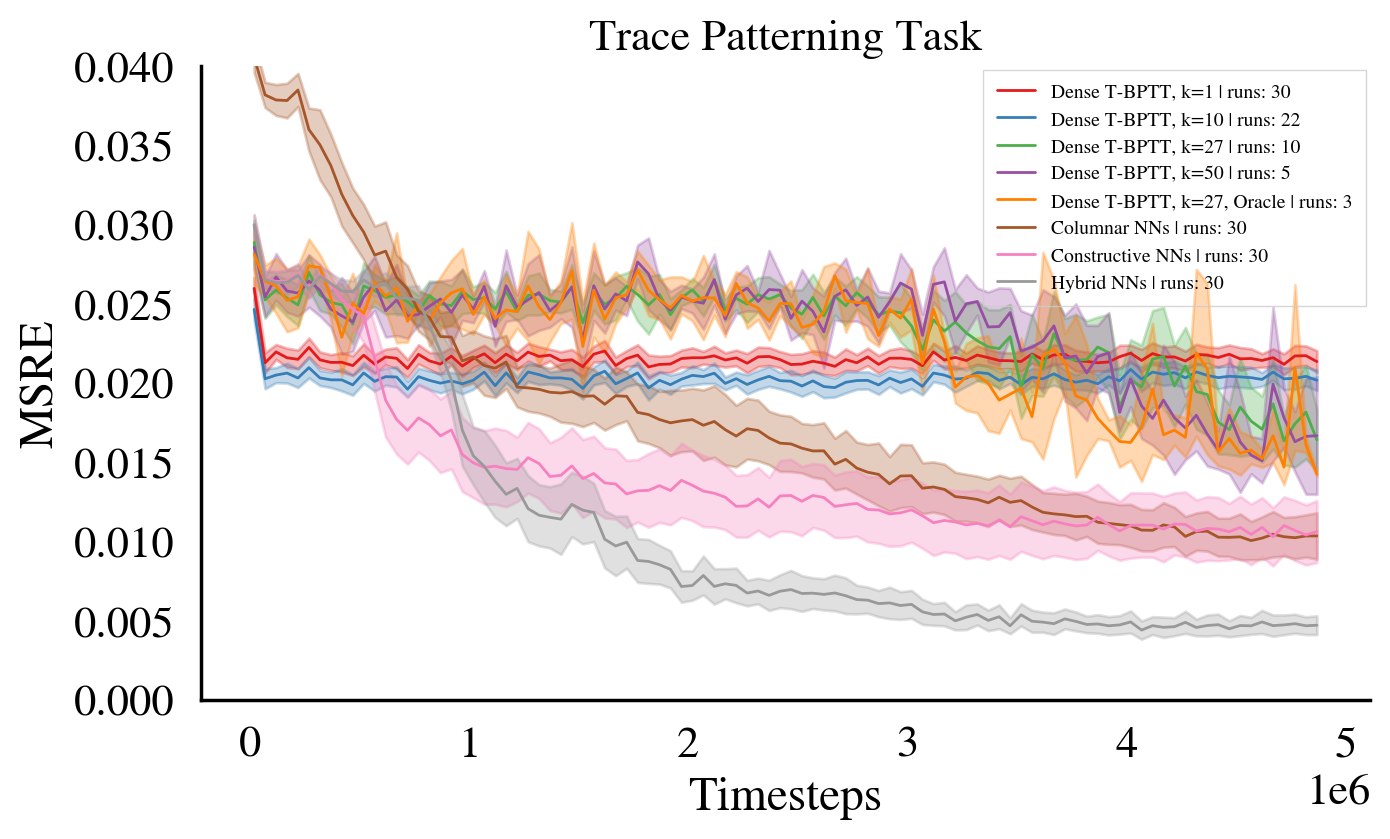

In [358]:
fig.axes[0].set_ylim(bottom=0, top=0.04)
fig.axes[0].set_yticks([0.0,0.005, 0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04])
fig

# Looking at the predictions

In [205]:
def plot_last_n(obsall, predall, targets, n=1000, nobs=7):
    fig, axs = plt.subplots(nobs+2,figsize=(15, 17))
    fig.tight_layout()
    for i in range(nobs):
        axs[i].step(list(range(n)), obsall[:, i][-n:])
        axs[i].title.set_text('CS')
        
    axs[-2].step(list(range(n)), targets[-n:] )
    axs[-1].step(list(range(n)), predall[-n:] )

    axs[6].title.set_text('US')
    axs[-2].title.set_text('return target')
    axs[-1].title.set_text('return prediction')

    for ax in axs:
        ax.grid(color='#666666', linestyle='-', alpha=0.5)
        ax.label_outer()
    return fig

Text(0.5, 0.98, 'Hybrid NNs')

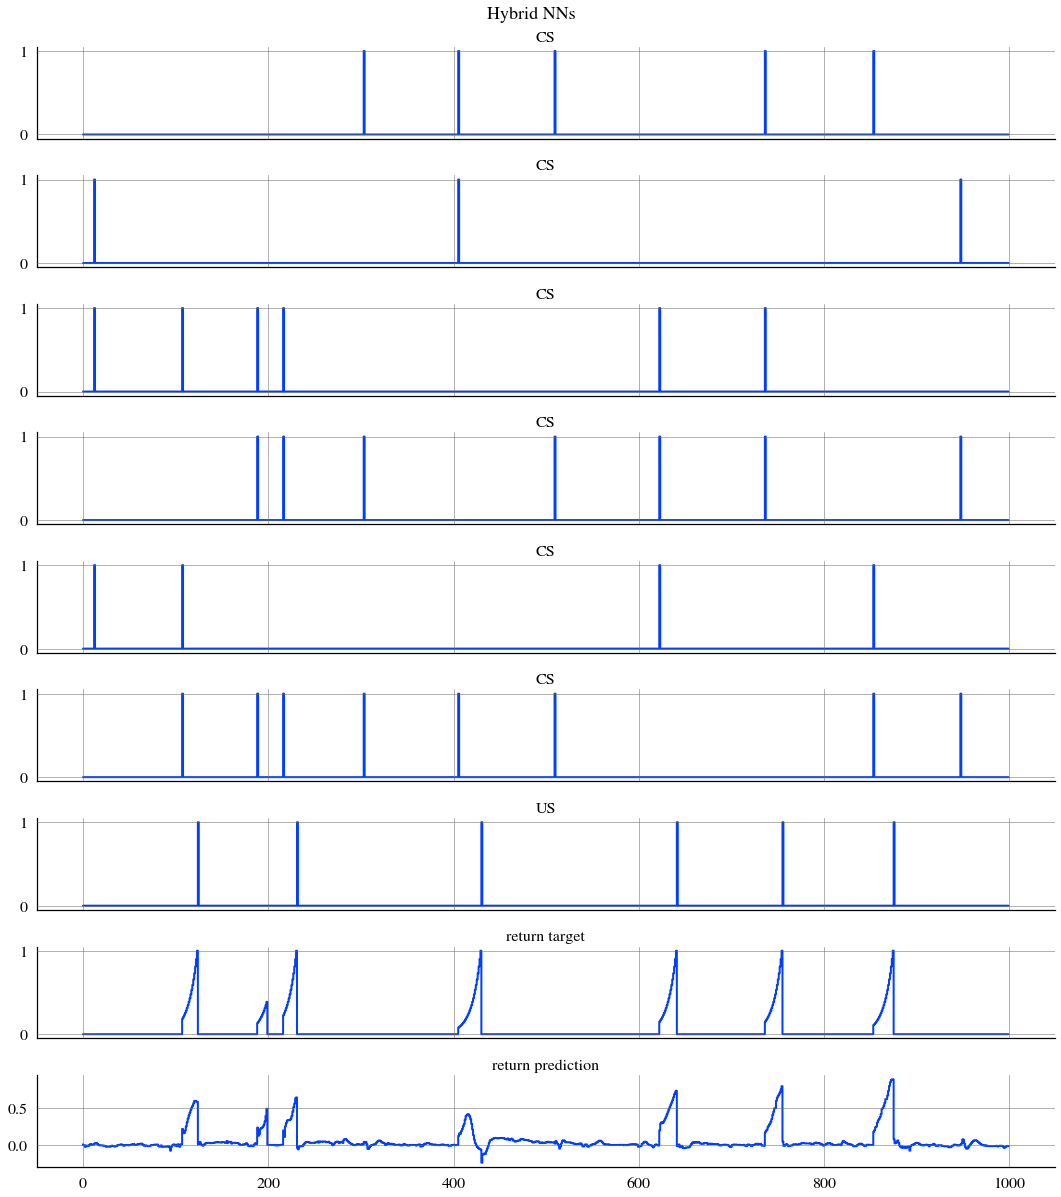

In [294]:
conditions = [['width', 20],
             ['lambda', 0.99],
             ['step_size', 1e-2],
             ['freq', 800000]]
run = pd.read_sql(f'select run from runs where {conditions[0][0]} = {conditions[0][1]} and {conditions[1][0]} = {conditions[1][1]}  and {conditions[2][0]} = {conditions[2][1]}  and {conditions[3][0]} = {conditions[3][1]}', db2.conn).values[0][0]
pred_table = pd.read_sql(f'select * from predictions where run={run}', db2.conn)
obs = pred_table.values[:,2:9]
pred = pred_table.values[:,9]
target = pred_table.values[:,10]
fig=plot_last_n(obs, pred, target, nobs=7)
fig.suptitle('Hybrid NNs')

Text(0.5, 0.98, 'Constructive NNs')

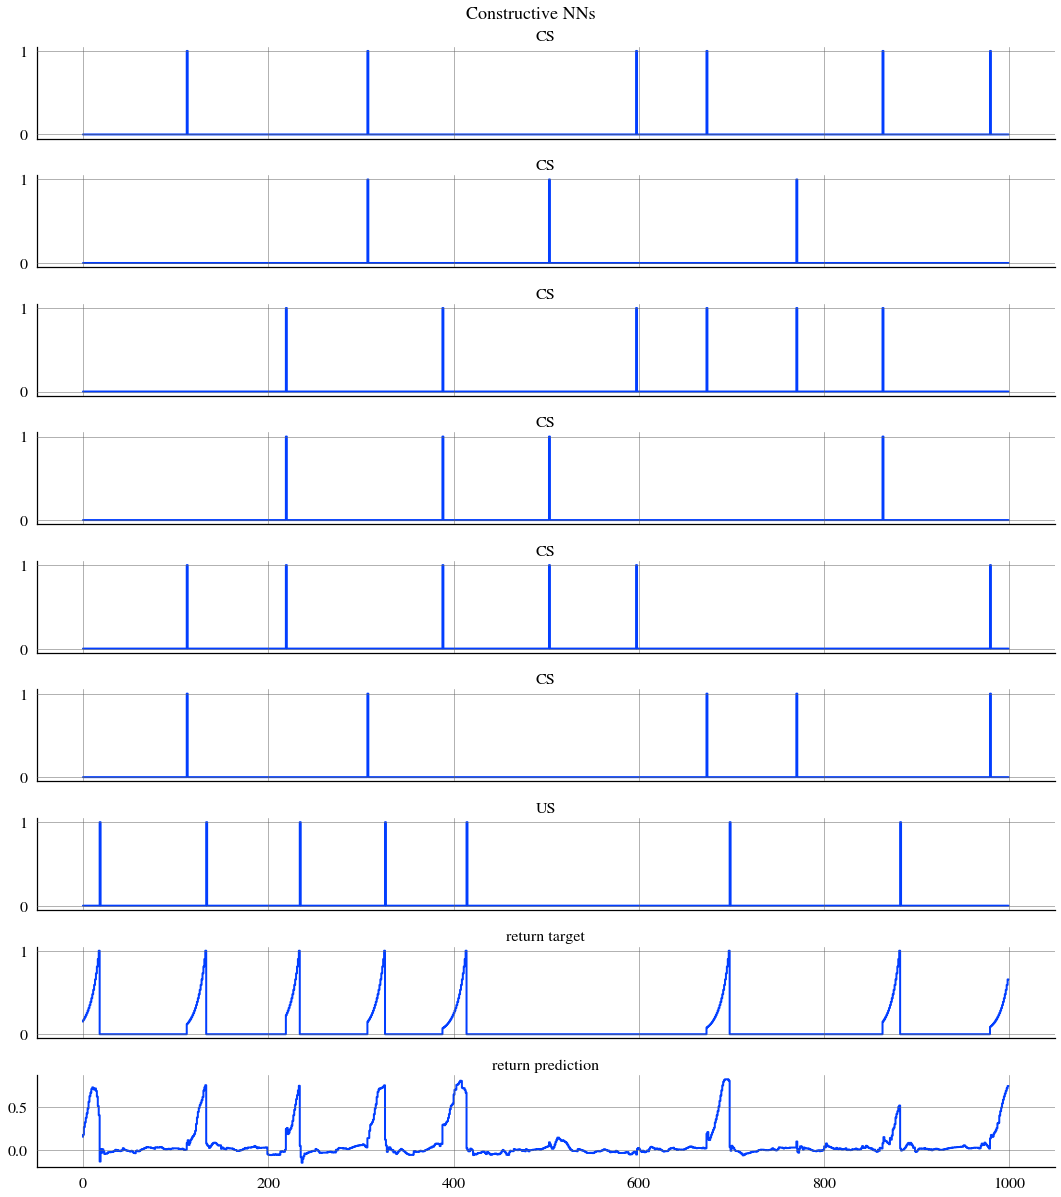

In [291]:
conditions = [['width', 1],
             ['lambda', 0.99],
             ['step_size', 1e-2],
             ['freq', 400000]]
run = pd.read_sql(f'select run from runs where {conditions[0][0]} = {conditions[0][1]} and {conditions[1][0]} = {conditions[1][1]}  and {conditions[2][0]} = {conditions[2][1]}  and {conditions[3][0]} = {conditions[3][1]}', db2.conn).values[0][0]
pred_table = pd.read_sql(f'select * from predictions where run={run}', db2.conn)
obs = pred_table.values[:,2:9]
pred = pred_table.values[:,9]
target = pred_table.values[:,10]
fig=plot_last_n(obs, pred, target, nobs=7)
fig.suptitle('Constructive NNs')

Text(0.5, 0.98, 'Columnar NN')

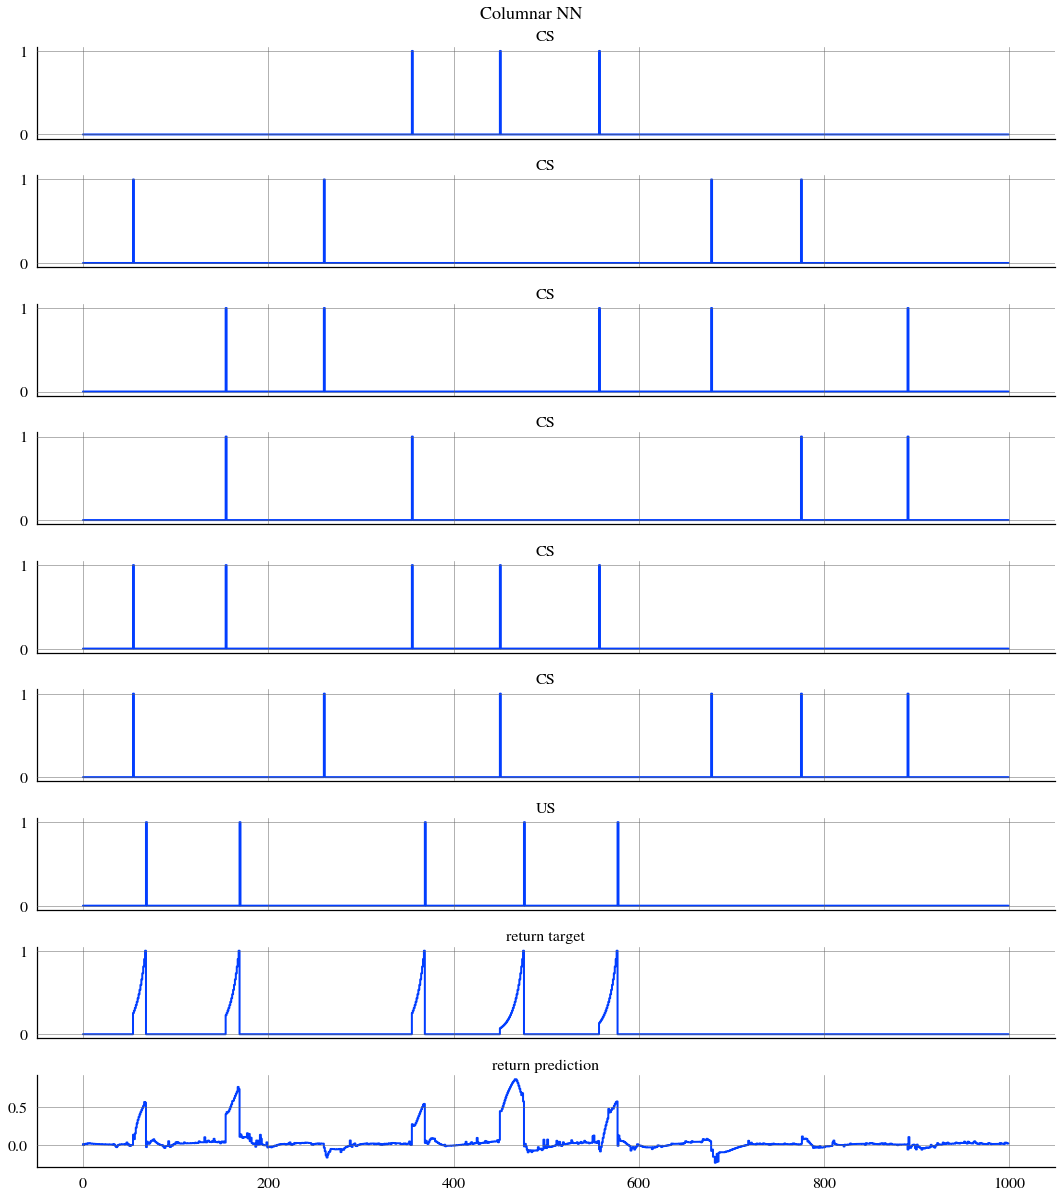

In [292]:
conditions = [['width', 200],
             ['lambda', 0.9],
             ['step_size', 0.1]]
run = pd.read_sql(f'select run from runs where {conditions[0][0]} = {conditions[0][1]} and {conditions[1][0]} = {conditions[1][1]} and {conditions[2][0]} = {conditions[2][1]}', db2.conn).values[0][0]
pred_table = pd.read_sql(f'select * from predictions where run={run}', db2.conn)
obs = pred_table.values[:,2:9]
pred = pred_table.values[:,9]
target = pred_table.values[:,10]
fig=plot_last_n(obs, pred, target, nobs=7)
fig.suptitle('Columnar NN')

Text(0.5, 0.98, 'T-BPTT, k=27, Oracle')

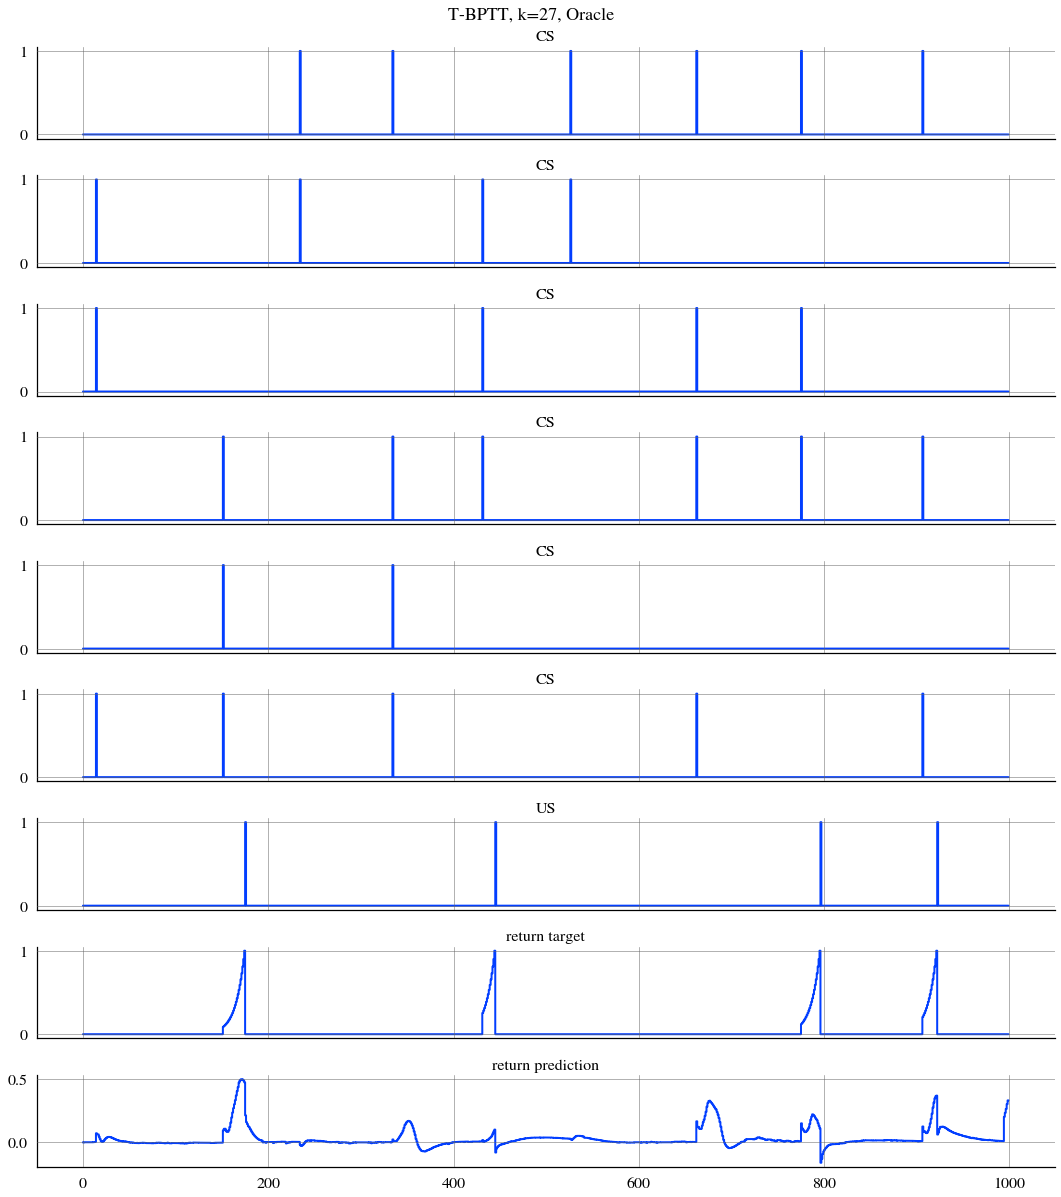

In [254]:
conditions = [['step_size', 0.1],
              ['lambda', 0.0],
              ['truncation', 27]]
run = pd.read_sql(f'select run from runs where {conditions[0][0]} = {conditions[0][1]} and {conditions[1][0]} = {conditions[1][1]} and {conditions[2][0]} = {conditions[2][1]}', db3.conn).values[0][0]
pred_table = pd.read_sql(f'select * from predictions where run={run}', db3.conn)
obs = pred_table.values[:,2:9]
pred = pred_table.values[:,9]
target = pred_table.values[:,10]
fig=plot_last_n(obs, pred, target, nobs=7)
fig.suptitle('T-BPTT, k=27, Oracle')

5000004.0


Text(0.5, 0.98, 'T-BPTT, k=50')

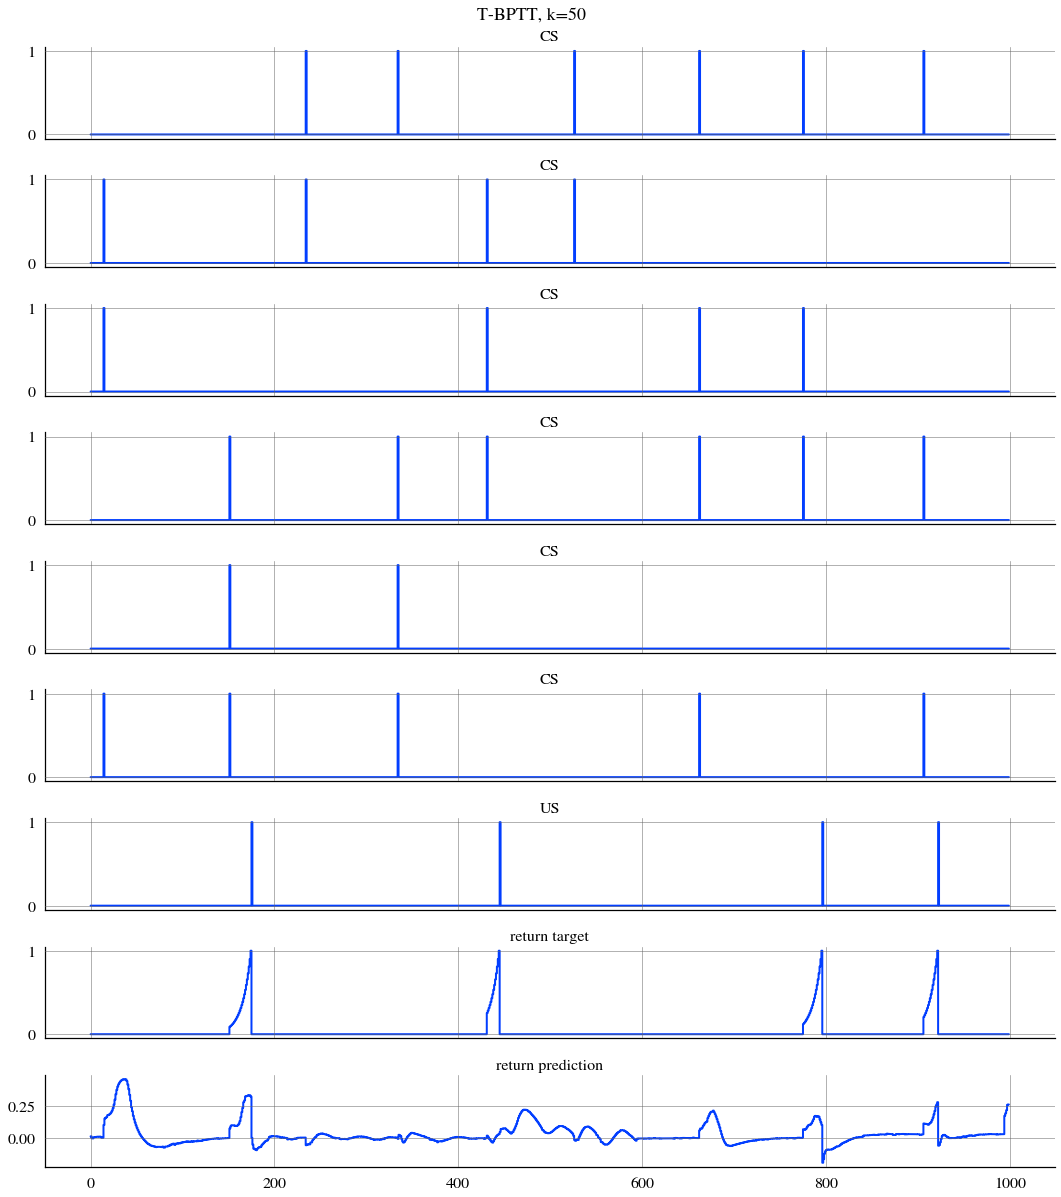

In [274]:
conditions = [['step_size', 0.1],
              ['lambda', 0.0],
              ['truncation', 50]]
run = pd.read_sql(f'select run from runs where {conditions[0][0]} = {conditions[0][1]} and {conditions[1][0]} = {conditions[1][1]} and {conditions[2][0]} = {conditions[2][1]}', db1.conn).values[0][0]
pred_table = pd.read_sql(f'select * from predictions where run={run}', db1.conn)
print(max(pred_table['step']))
obs = pred_table.values[:,2:9]
pred = pred_table.values[:,9]
target = pred_table.values[:,10]
fig=plot_last_n(obs, pred, target, nobs=7)
fig.suptitle('T-BPTT, k=50')

5000004.0


Text(0.5, 0.98, 'T-BPTT, k=27')

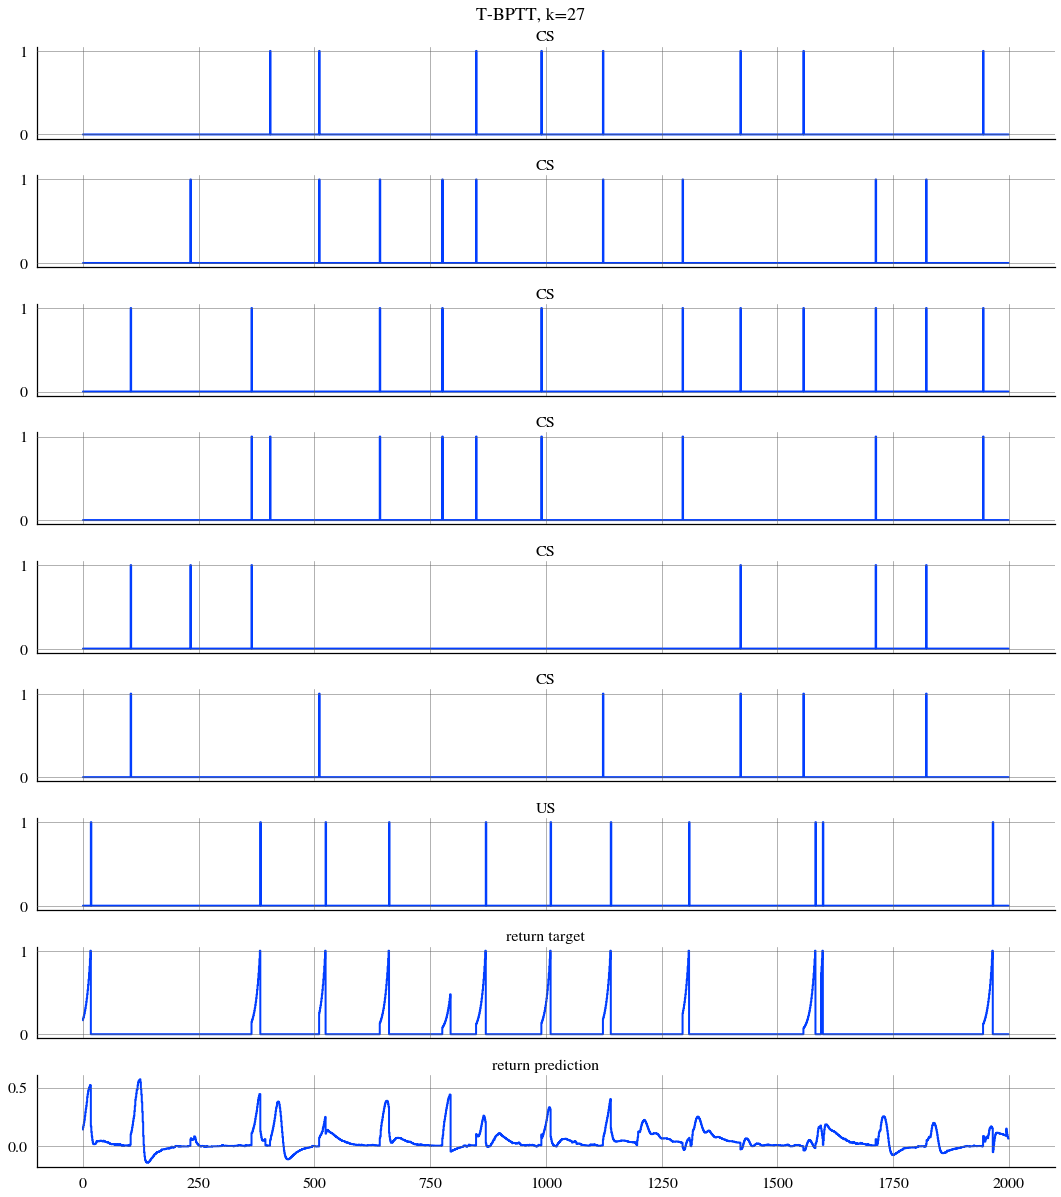

In [312]:
conditions = [['step_size', 0.1],
              ['lambda', 0.0],
              ['truncation', 27]]
run = pd.read_sql(f'select run from runs where {conditions[0][0]} = {conditions[0][1]} and {conditions[1][0]} = {conditions[1][1]} and {conditions[2][0]} = {conditions[2][1]}', db1.conn).values[1][0]
pred_table = pd.read_sql(f'select * from predictions where run={run}', db1.conn)
print(max(pred_table['step']))
obs = pred_table.values[:,2:9]
pred = pred_table.values[:,9]
target = pred_table.values[:,10]
fig=plot_last_n(obs, pred, target, n=2000, nobs=7)
fig.suptitle('T-BPTT, k=27')

Text(0.5, 0.98, 'T-BPTT, k=27')

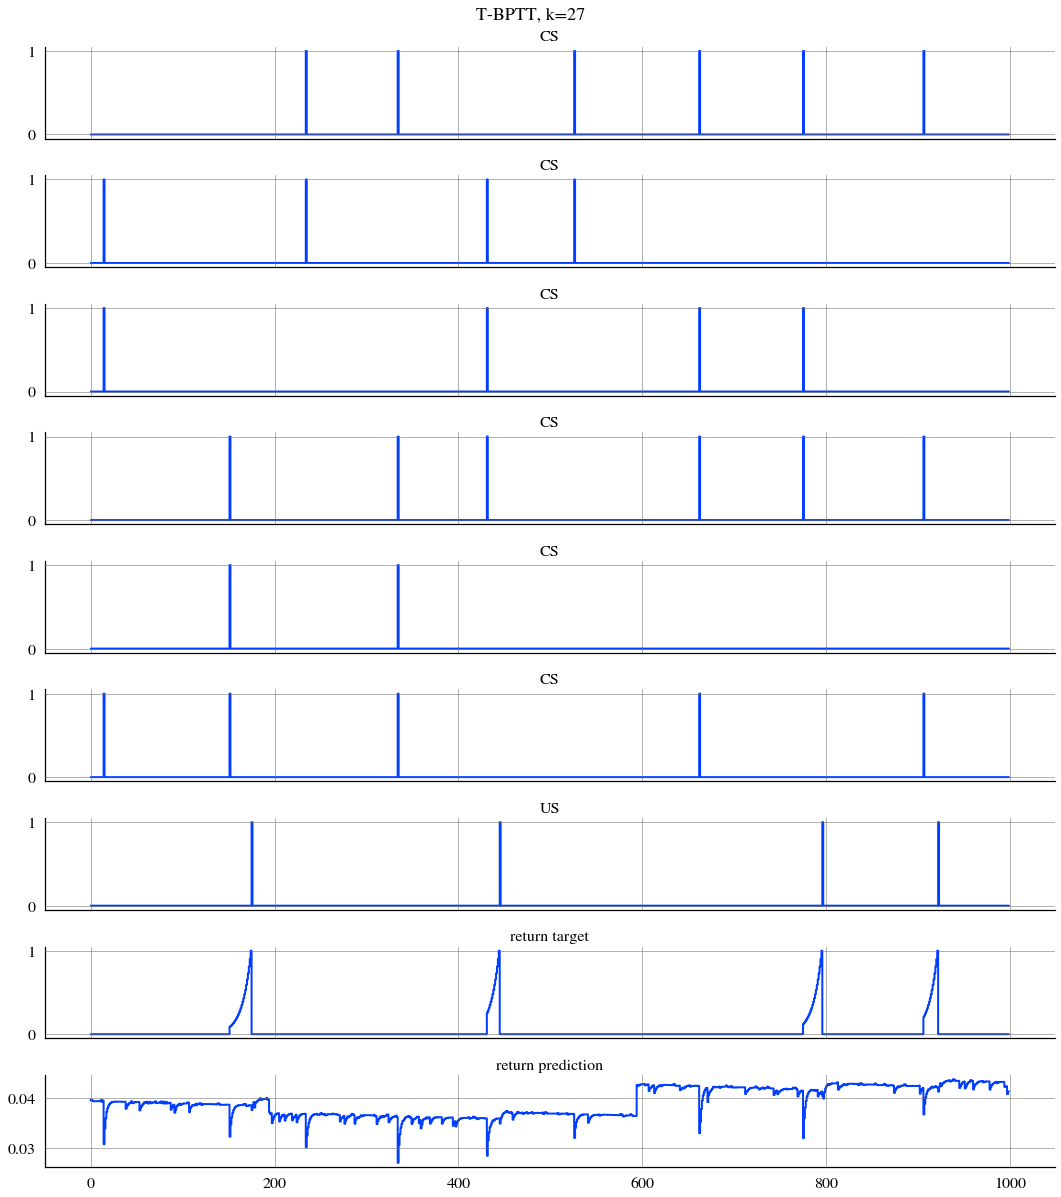

In [228]:
conditions = [['step_size', 0.0003],
              ['lambda', 0.5],
              ['truncation', 10]]
run = pd.read_sql(f'select run from runs where {conditions[0][0]} = {conditions[0][1]} and {conditions[1][0]} = {conditions[1][1]} and {conditions[2][0]} = {conditions[2][1]}', db1.conn).values[0][0]
pred_table = pd.read_sql(f'select * from predictions where run={run}', db1.conn)
obs = pred_table.values[:,2:9]
pred = pred_table.values[:,9]
target = pred_table.values[:,10]
fig=plot_last_n(obs, pred, target, nobs=7)
fig.suptitle('T-BPTT, k=27')

Text(0.5, 0.98, 'T-BPTT, k=27')

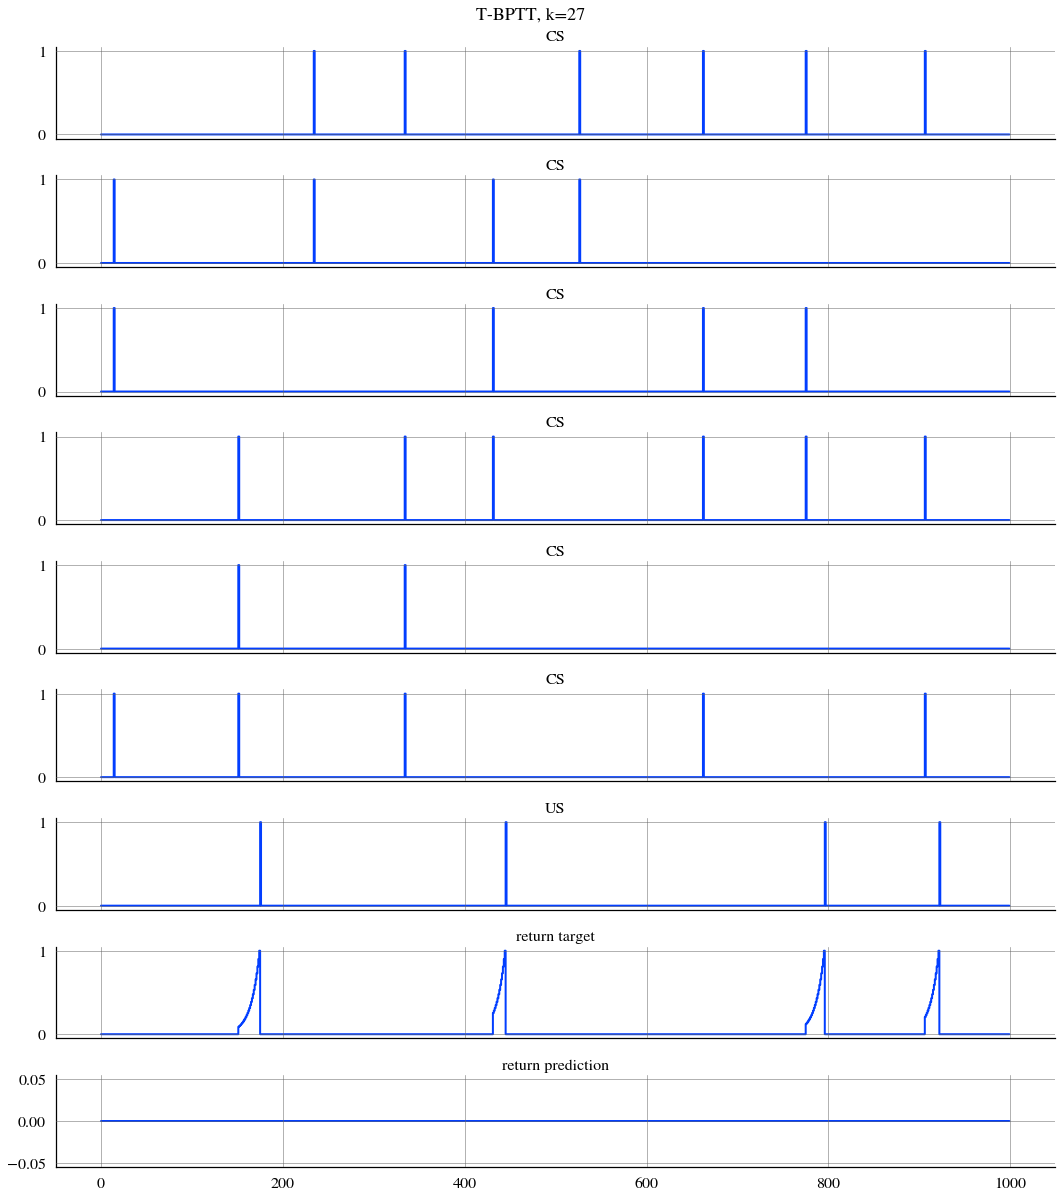

In [229]:
conditions = [['step_size', 0.003],
              ['lambda', 0.99],
              ['truncation', 1]]
run = pd.read_sql(f'select run from runs where {conditions[0][0]} = {conditions[0][1]} and {conditions[1][0]} = {conditions[1][1]} and {conditions[2][0]} = {conditions[2][1]}', db1.conn).values[0][0]
pred_table = pd.read_sql(f'select * from predictions where run={run}', db1.conn)
obs = pred_table.values[:,2:9]
pred = pred_table.values[:,9]
target = pred_table.values[:,10]
fig=plot_last_n(obs, pred, target, nobs=7)
fig.suptitle('T-BPTT, k=27')